# Final version for ball detection

* all old versions are in backup_notebooks.py or detect_ball_thresh.py
* this version: employ metric including area differences, slope, distance, angle diagonals of rectangle
* search in graph for moment when this metric is smaller the threshold

In [109]:
import cv2
import math
from matplotlib import pyplot as plt
import numpy as np
import os
import time
import json
%matplotlib inline

def from_json(file):
    coordinates = ["x", "y"]
    joints_list = ["right_shoulder", "right_elbow", "right_wrist", "left_shoulder","left_elbow", "left_wrist",
            "right_hip", "right_knee", "right_ankle", "left_hip", "left_knee", "left_ankle",
            "right_eye", "right_ear","left_eye", "left_ear", "nose ", "neck"]
    with open(file, 'r') as inf:
        out = json.load(inf)

    liste = []
    for fr in out["frames"]:
        l_joints = []
        for j in joints_list[:12]:
            l_coo = []
            for xy in coordinates:
                l_coo.append(fr[j][xy])
            l_joints.append(l_coo)
        liste.append(l_joints)

    return np.array(liste)

class Node():
    def __init__(self, x1, y1, x2, y2):
        self.bbox = [x1, y1, x2, y2]
        self.l = abs(x1-x2)
        self.w = abs(y1-y2)
        self.angle = np.arctan(self.l/self.w)
        self.area = self.l*self.w # (l+w)/float(l*w)
        self.center = np.array([(x1+x2)/2, (y1+y2)/2])
        self.children = []
        self.area_diffs = []
        self.angle_diffs = []
        self.slopes = []
        self.dist = []
    def add_child(self, no):
        dist = np.linalg.norm(no.center-self.center)
        if dist>10: 
            self.children.append(no)
            self.area_diffs.append(abs(1-(no.area/self.area)))
            y_diff = (self.center[1]-no.center[1])
            slope = np.arctan(y_diff/(self.center[0]-no.center[0]))
            if y_diff<0:
                slope+=np.pi
            self.slopes.append(slope)
            self.dist.append(dist)
            self.angle_diffs.append(abs(self.angle-no.angle))
    def favourite_child(self, no):
        self.fav_child=no
        

In [150]:
def get_difference(im_tm1, im_t, im_tp1):
    """
    calculates difference image and applies threshold to detect significant motion
    parameters: three consecutive frames
    returns binary image of same size as input frames indicating significantly different pixels
    """
    delta_plus = cv2.absdiff(im_t, im_tm1)
    delta_0 = cv2.absdiff(im_tp1, im_tm1)
    delta_minus = cv2.absdiff(im_t,im_tp1)
    sp = cv2.meanStdDev(delta_plus)
    sm = cv2.meanStdDev(delta_minus)
    s0 = cv2.meanStdDev(delta_0)
    # print("E(d+):", sp, "\nE(d-):", sm, "\nE(d0):", s0)

    th = [
        sp[0][0, 0] + 3 * math.sqrt(sp[1][0, 0]),
        sm[0][0, 0] + 3 * math.sqrt(sm[1][0, 0]),
        s0[0][0, 0] + 3 * math.sqrt(s0[1][0, 0]),
    ]

    # OPENCV THRESHOLD

    ret, dbp = cv2.threshold(delta_plus, th[0], 255, cv2.THRESH_BINARY)
    ret, dbm = cv2.threshold(delta_minus, th[1], 255, cv2.THRESH_BINARY)
    ret, db0 = cv2.threshold(delta_0, th[2], 255, cv2.THRESH_BINARY)

    detect = cv2.bitwise_and(cv2.bitwise_and(dbp, dbm), cv2.bitwise_not(db0))
    # nd = cv2.bitwise_not(detect)
    return detect


def get_candidates(nd, min_area):
    """
    find connected components in a binary difference image
    nd is a binary image indicating significant pixel changes
    min_area is the minimum area of pixels in nd that should be recognized as a connected region
    return list of candidates, each is a tuple (left_top_corner, right_bottom_corner, area)
    """
    # only stats is used, not num, labels, centroids
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(nd, ltype=cv2.CV_16U)
    # We set an arbitrary threshold to screen out smaller "components"
    # which may result simply from noise, or moving leaves, and other
    # elements not of interest.
    candidates = list()
    for stat in stats[1:]:
        area = stat[cv2.CC_STAT_AREA]
        if area < min_area:
            continue # Skip small objects (noise)

        lt = (stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP])
        rb = (lt[0] + stat[cv2.CC_STAT_WIDTH], lt[1] + stat[cv2.CC_STAT_HEIGHT])
        #if np.any(np.array(lt)==0) or np.any(np.array(rb)==0):
         #   continue
        bottomLeftCornerOfText = (lt[0], lt[1] - 15)

        candidates.append((lt, rb, area))
    return candidates


def first_movement(cand_list, joints, ankle_move, fr):
    knees= joints[[7, 10],:]
    ankles = joints[[8,11],:]
    #print(knees, ankles, knees-ankles, np.mean(knees-ankles, axis=0))
    dist_ankle = np.linalg.norm(np.mean(knees-ankles, axis=0)) #//2
    #print("radius", dist_ankle)
    for k, cand in enumerate(cand_list):
        x1, y1 = cand[0]
        x2, y2 = cand[1]
        center = [(x1+x2)/2, (y1+y2)/2]
              #np.linalg.norm(cand.center - knees[0]), 
            #np.linalg.norm(cand.center - knees[1]), np.linalg.norm(cand.center - ankles[1]), 
                #                                     np.linalg.norm(cand.center - ankles[0]))
        #print(np.linalg.norm(cand.center - knees[0])<radius, np.linalg.norm(cand.center - knees[1])<radius)
        norms = np.array([np.linalg.norm(center - knees[0]), np.linalg.norm(center - knees[1]), np.linalg.norm(center - ankles[0]), np.linalg.norm(center - ankles[1])])
        #print("center", cand.center, "knees", knees[0],knees[1], "ankles", ankles, "norms", norms)
        if np.any(norms<dist_ankle):
            print("smaller radius", center)
            ankle_move.append(fr) #cand.center)
            break
    return ankle_move
        #if k==len(candidates_per_frame[-1])-1:
         #   ankle_move=[]
    #print(t, ankle_move)

def plot(im_t, candidates, frame_nr):
    #print("DETECTED", t-1, whiteness_values[-1], candidate_values[-1])
    plt.figure(figsize=(10, 10), edgecolor='r')
    # print(candidates[fom])
    img = np.tile(np.expand_dims(im_t.copy(), axis = 2), (1,1,3))
    #print(img.shape)
    #for jo in ankles:
     #   cv2.circle(img, (int(jo[0]), int(jo[1])), 8, [255,0,0], thickness=-1)
    #for kn in knees:
     #   cv2.circle(img, (int(kn[0]), int(kn[1])), 8, [255,0,0], thickness=-1)
    for can in candidates: # einfuegen falls alles plotten
        cv2.rectangle(img, can[0], can[1],[255,0,0], 4)
    #cv2.rectangle(img,tuple(balls[-1][:2]), tuple(balls[-1][2:]), [255,0,0], 4)
    plt.imshow(img, 'gray')
    plt.title("Detected FMO frame"+ str(frame_nr))
    plt.show()


def add_candidate(candidate, candidates_per_frame):
    # The first two elements of each `candidate` tuple are
    # the opposing corners of the bounding box.
    x1, y1 = candidate[0]
    x2, y2 = candidate[1]
    no = Node(x1, y1, x2, y2)
    #print("area_cand[3]:", candidate[2], "area node", no.area)
    candidates_per_frame[-1].append(no)
    if candidates_per_frame[-2]!=[]:
        for nodes_in in candidates_per_frame[-2]:
            nodes_in.add_child(no)
            # print("previous detection", nodes.bbox, "gets child", no.bbox)
    return candidates_per_frame

def ball_detection(candidates_per_frame, balls, metric_thresh =0.5):
    if len(balls)==0:
        for cands3 in candidates_per_frame[-3]:
            for j, cands2 in enumerate(cands3.children): # counts through children (ebene 2)
                slope = cands3.slopes[j] # slope of 3 to 2
                dist = cands3.dist[j]
                area = cands3.area_diffs[j]
                angle = cands3.angle_diffs[j]
                #print("j", j, slope, dist, area, angle)
                for k, cands1 in enumerate(cands2.children):
                    #print("k", k, cands2.slopes[k], cands2.dist[k], cands2.area_diffs[k], cands2.angle_diffs[k])
                    #print("metric: ", abs(slope-cands2.slopes[k]), abs(1- dist/cands2.dist[k]), area, cands2.area_diffs[k])
                    metric = abs(slope-cands2.slopes[k]) + abs(1- dist/cands2.dist[k]) #+ area+cands2.area_diffs[k] + angle + cands2.angle_diffs[k] 
                    if metric<metric_thresh:
                        balls = [cands3, cands2, cands1]
                    # if abs(slope-cands2.slopes[k]) < 0.1 and abs(dist-cands2.dist[k])<10:
                        return balls
    else:
        j = balls[-2].children.index(balls[-1])
        slope = balls[-2].slopes[j] # slope of 3 to 2
        dist = balls[-2].dist[j]
        area = balls[-2].area_diffs[j]
        angle = balls[-2].angle_diffs[j]
        for k, cands1 in enumerate(balls[-1].children):
            #print("k", k, balls[-1].slopes[k], balls[-1].dist[k], balls[-1].area_diffs[k], balls[-1].angle_diffs[k])
            #print("metric: ", abs(slope-balls[-1].slopes[k]), abs(1- dist/balls[-1].dist[k]), area, balls[-1].area_diffs[k])
            metric = abs(slope-balls[-1].slopes[k]) + abs(1- dist/balls[-1].dist[k]) # + area+balls[-1].area_diffs[k] + angle + balls[-1].angle_diffs[k] 
            if metric<metric_thresh:
                balls.append(cands1)
            # if abs(slope-cands2.slopes[k]) < 0.1 and abs(dist-cands2.dist[k])<10:
                return balls
    return []

def distance_projected(p, p1,p2):
    """
    returns distance of p' (= p projected on line spanned by p1 and p2) from p1
    """
    v1 = p-p1
    v2 = p2-p1
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0) * np.linalg.norm(v1)

def _get_max_array(array_list):
    """
    returns union of the binary images in array_list
    """
    resultant_array = np.zeros(array_list[0].shape)
    for array in array_list:
        resultant_array = np.maximum(resultant_array, array)
    return resultant_array

def trajectory_and_speed(balls, im_t, t, fps = 30, factor_pixel_feet=10, plotting=True):
    #plot(im_t, candidates, t)
    trajectory = np.array([elem.center for elem in balls]).astype(int)
    # print("trajectory", trajectory.tolist())
    # distance
    dist_from_start = distance_projected(trajectory[0], np.array([110, 140]),np.array([690, 288]))
    speed = np.mean([np.linalg.norm(trajectory[i]- trajectory[i+1]) for i in range(len(trajectory)-1)])
    frames_shifted = dist_from_start/speed + len(balls)-1 # frames because current frame is already after nth ball detection
    # print("frames from release frame (using distance from center of base projected)", frames_shifted)
    #plt.scatter(trajectory[:,0], trajectory[:,1])
    #plt.show()
    ball_release = round(t - frames_shifted)
    if plotting:
        plt.figure(figsize=(10, 10), edgecolor='r')
        img = np.tile(np.expand_dims(im_t.copy(), axis = 2), (1,1,3))
        # img = cv2.line(img, (110, 140),(690, 288), color = 2) # line from center of base to center of pitchers mound
        for i in range(len(trajectory)-1):
            img = cv2.line(img, tuple(trajectory[i]),tuple(trajectory[i+1]), color = 2)
        # img = cv2.line(img, tuple(trajectory[1]),tuple(trajectory[2]), color = 2)
        plt.imshow(img, 'gray')
        plt.title("Ball trajectory at frame "+str(t)+ ", speed in mph: "+ str(speed*fps* 0.681818 /factor_pixel_feet))
        plt.show()
        # print("SPEED in mph", speed*fps* 0.681818 /factor_pixel_feet) # 1 ft/s = 0.681818 mph
        print("")
    return ball_release

In [149]:
def detect_ball(folder, joints_array=None, min_area = 400, plotting=True, min_length_first=5, every_x_frame=1, roi=None):
    """
    roi: region of interest if not the whole frame is relevant, format: list [top, bottom, left, right] with top<bottom
    """
    fps = 30
    factor_pixel_feet = 10
    cap = cv2.VideoCapture(folder)
    images=[]
    motion_images=[]
    start = time.time()

    candidates_per_frame = []
    location = []
    frame_indizes = []
    ankle_move=[]
    balls = []
    t=0 # frame count
    first_move_found = False
    ball_release_found = False

    # function returns
    ball_release = 0 # if not found
    first_move_frame = 0 # if not found
    ball_trajectory = []

    while t<300:
        ret, frame = cap.read()
        if frame is None:
            break

        candidates_per_frame.append([])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if roi is not None:
            frame = frame[roi[0]:roi[1], roi[2]:roi[3]]

        # HERE INSERT FIRST MOVE QUALITATIVE EVALUATION

        if t>1:
            im_tm1 = images[-2]
            im_t = images[-1]
            im_tp1 = frame

            nd = get_difference(im_tm1, im_t, im_tp1)
            if t<11:
                motion_images.append(nd)
        if t<11:
            images.append(frame)
            t+=1
            continue
        im_every_x_0 = images[-2*every_x_frame]
        im_every_x_1 = images[-every_x_frame]
        im_every_x_2 = images[-1]

        cumulative_motion = _get_max_array(motion_images)
        final_frame = nd.astype(int) - cumulative_motion.astype(int)
        final_frame[final_frame < 0] = 0
        candidates = get_candidates(final_frame.astype(np.uint8), min_area)

        # NORMAL CANDIDATES (THREE IN A ROW)
        # candidates = get_candidates(im_tm1, im_t, im_tp1, min_area)
        #plt.figure(figsize=(10, 10), edgecolor='k')

        ### HERE INSERT RELEASE FRAME CLOSE TO WRIST
        for i, candidate in enumerate(candidates):
            if t>0:
                candidates_per_frame = add_candidate(candidate, candidates_per_frame)
            ### HERE INSERT CLOSE TO WRIST
            ### HERE INSERT SHORTEST PATH CODE
            #save location of candidate and frame
            #location.append(center)
            frame_indizes.append(t-1)

        ### BALL DETECTION:
        l = np.array([len(candidates_per_frame[-i-1]) for i in range(3)])
        if np.all(l>0) and len(balls)==0:
            balls = ball_detection(candidates_per_frame, balls)
            if len(balls)==3:
                est_ball_release = trajectory_and_speed(balls, im_t, t, plotting = False)
                if not ball_release_found:
                    ball_release_found = True
                    ball_release = est_ball_release
                    print("\nRELEASE FRAME AT ", ball_release, "\n")
                counter = 0
        elif len(balls)>0:
            if len(candidates_per_frame)>0:
                new_balls = ball_detection(candidates_per_frame, balls)
                if len(new_balls)==0 and counter>-1: # change from -1 to higher number to allow missing balls
                    # inbetween (problem: speed then calculated wrong because len(balls))
                    # problem 2: dist in metric - also there some number indicating this
                    # general problem: candidates not in balls[-1].children
                    _ = trajectory_and_speed(balls, im_t, t-1)
                    for b in balls:
                        ball_trajectory.append(b.center)
                    balls = []
                    # break
                else:
                    balls = new_balls
            else:
                _ = trajectory_and_speed(balls, im_t, t-1)
                for b in balls:
                    ball_trajectory.append(b.center)
                balls = []
                # break
        else:
            balls=[]

        # FIRST MOVEMENT --> SHIFtED CANDIDATES

        if not first_move_found and joints_array is not None:
        # SHIFTED CANDIDATES:
            detected_moves = get_difference(im_every_x_0, im_every_x_1, im_every_x_2)
            shifted_candidates = get_candidates(detected_moves, min_area)
            #plt.figure(figsize=(10, 10), edgecolor='k')

            ### FIRST MOVEMENT:
            if shifted_candidates!=[]:
                ankle_move = first_movement(shifted_candidates, joints_array[t-every_x_frame], ankle_move, t)
            if len(ankle_move)>=min_length_first and t-ankle_move[-min_length_first]<10: #len(ankle_move)==3:
                print("first movement frame: ", (ankle_move[-min_length_first]))
                plot(im_t, shifted_candidates, t)
                first_move_found = True
                first_move_frame = ankle_move[-min_length_first]
                range_joints = joints_array[first_move_frame -10: first_move_frame +10]
                grad = range_joints # np.gradient(range_joints, axis = 0) # OHNE GRADIENT; JUST HEIGHT OF LEG
                mean_gradient = np.mean(grad[:, [7,8,10,11],1], axis = 1)
                ### gradient plotting
                # plt.plot(grad[:,:,1])
                # plt.plot(mean_gradient, c="black")
                # plt.title("black: mean height of knees and ankles")
                # plt.show()
                first_move_frame = first_move_frame-10+np.argmin(mean_gradient)
                print("Refined first movement", first_move_frame)
                break

        if plotting and len(candidates)>0: #len(balls)>0: # ##
            plot(im_t, candidates, t)
            #plt.imshow(cumulative_motion.astype(int))
            #plt.show()

        t+=1
        images = np.roll(np.array(images), -1, axis=0)
        images[-1] = frame
        motion_images = np.roll(np.array(motion_images), -1, axis=0)
        motion_images[-1] = nd
    # print("time for %s frames"%t, (time.time() - start) * 1000)
    return ball_release, np.array(ball_trajectory), first_move_frame

trajectory [[163, 107], [207, 116], [252, 128]]
frames from release frame (using distance from center of base projected) 2.94432722512
RELEASE FRAME AT  98.0
trajectory [[163, 107], [207, 116], [252, 128]]
frames from release frame (using distance from center of base projected) 2.94432722512


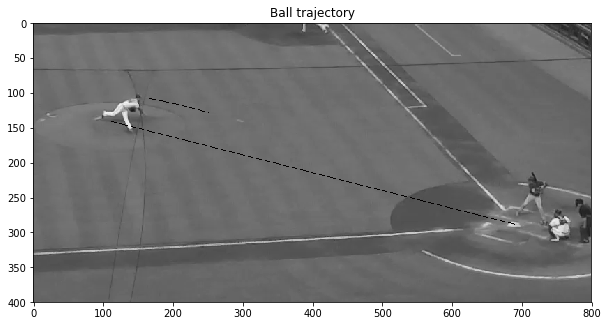

RELEASE FRAME AT  98.0 SPEED in mph 93.5626938126

trajectory [[342, 152], [388, 164], [434, 178]]
frames from release frame (using distance from center of base projected) 6.76380119975
RELEASE FRAME AT  98.0
trajectory [[342, 152], [388, 164], [434, 178], [481, 191], [529, 206], [577, 221], [624, 235], [673, 250]]
frames from release frame (using distance from center of base projected) 11.6179336677


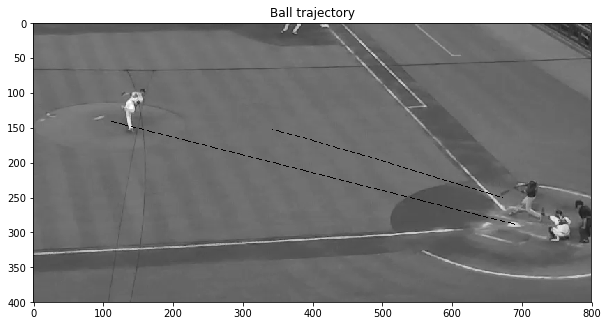

RELEASE FRAME AT  98.0 SPEED in mph 100.885034407

trajectory [[673, 250], [639, 240], [589, 223]]
frames from release frame (using distance from center of base projected) 14.9792715453
RELEASE FRAME AT  97.0
trajectory [[673, 250], [639, 240], [589, 223], [540, 207], [490, 192], [442, 178], [395, 165], [350, 153], [303, 140], [260, 128], [217, 118], [173, 108]]
frames from release frame (using distance from center of base projected) 23.1148649516


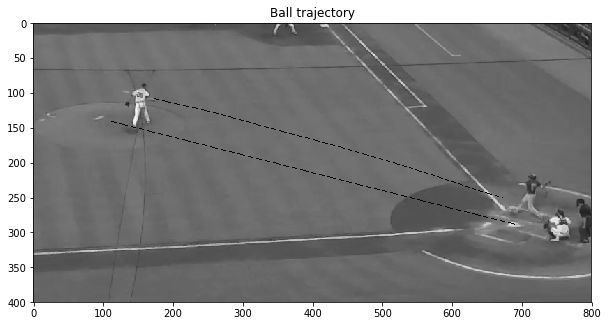

RELEASE FRAME AT  98.0 SPEED in mph 96.6966575078

trajectory [[94, 90], [55, 82], [18, 74]]
frames from release frame (using distance from center of base projected) 1.2824313901
RELEASE FRAME AT  124.0
trajectory [[94, 90], [55, 82], [18, 74]]
frames from release frame (using distance from center of base projected) 1.2824313901


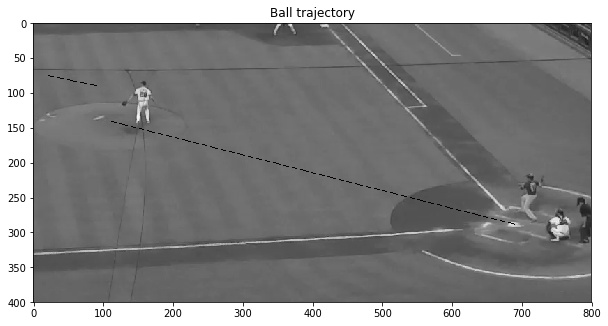

RELEASE FRAME AT  124.0 SPEED in mph 79.4321838666



In [148]:

BASE = "/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/demo_data/example_1.m4v"
box = [400, 800, 600, 1400]
ball_release, ball_trajectory, first_move_frame = detect_ball(BASE, joints_array = None, plotting=False, min_area=30, every_x_frame=4, roi=box)

------------------------------------------------------------------------
video: 490770-1c3452eb-5fc2-47bb-aff4-91a6fcfe493f.m4v
trajectory [[167, 116], [207, 126], [252, 138]]
frames from release frame (using distance from center of base projected) 3.12287578628
trajectory [[167, 116], [207, 126], [252, 138], [295, 148]]
frames from release frame (using distance from center of base projected) 4.12078501657


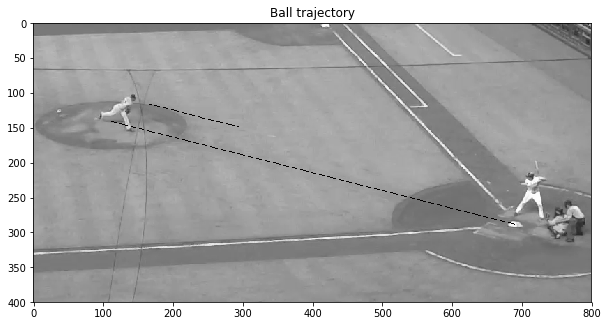

RELEASE FRAME AT  94.0 SPEED in mph 89.9666081368

trajectory [[432, 186], [479, 201], [525, 215]]
frames from release frame (using distance from center of base projected) 8.63887889769
trajectory [[432, 186], [479, 201], [525, 215], [571, 229], [618, 245], [664, 259], [714, 277]]
frames from release frame (using distance from center of base projected) 12.546614218


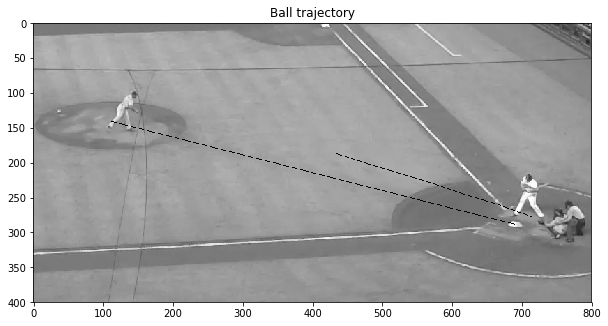

RELEASE FRAME AT  94.0 SPEED in mph 101.037060421

trajectory [[688, 212], [662, 203], [638, 192]]
frames from release frame (using distance from center of base projected) 23.4360621188
trajectory [[688, 212], [662, 203], [638, 192], [614, 184]]
frames from release frame (using distance from center of base projected) 24.8850041338


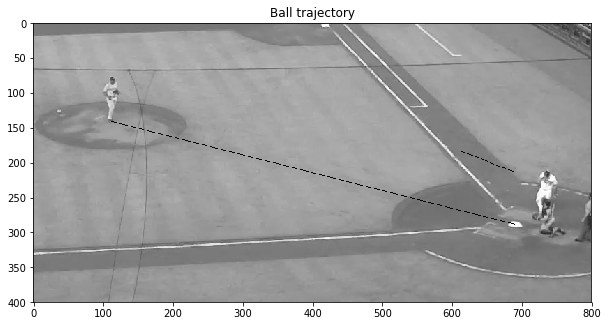

RELEASE FRAME AT  142.0 SPEED in mph 54.0085845731

------------------------------------------------------------------------
video: 490770-1ccdbdae-0b31-49ab-a08c-a4ceded9e778.m4v
trajectory [[186, 120], [227, 131], [270, 141]]
frames from release frame (using distance from center of base projected) 3.58654416569
trajectory [[186, 120], [227, 131], [270, 141], [311, 154], [354, 164], [398, 177]]
frames from release frame (using distance from center of base projected) 6.56383922838


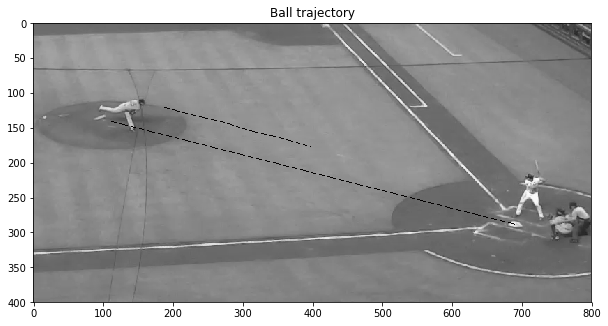

RELEASE FRAME AT  98.0 SPEED in mph 89.8514089877

trajectory [[485, 203], [529, 217], [575, 231]]
frames from release frame (using distance from center of base projected) 10.0404483395
trajectory [[485, 203], [529, 217], [575, 231], [619, 247], [665, 262], [710, 277]]
frames from release frame (using distance from center of base projected) 12.9979683831


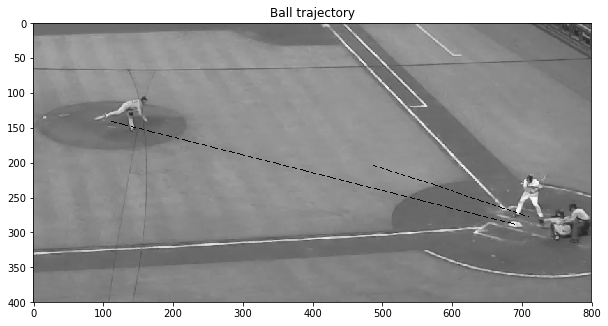

RELEASE FRAME AT  99.0 SPEED in mph 96.9110303034

trajectory [[697, 214], [677, 205], [657, 196]]
frames from release frame (using distance from center of base projected) 28.7681416149
trajectory [[697, 214], [677, 205], [657, 196], [637, 187], [617, 180], [597, 171]]
frames from release frame (using distance from center of base projected) 31.9505238258


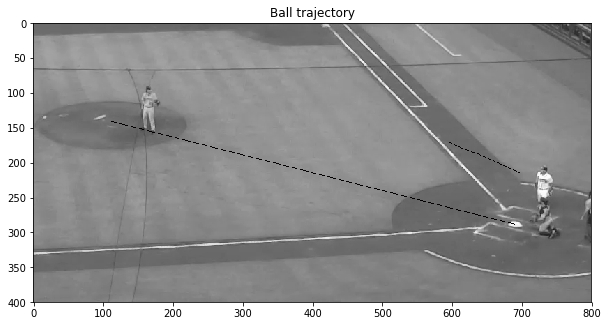

RELEASE FRAME AT  140.0 SPEED in mph 44.5567253948

------------------------------------------------------------------------
video: 490770-1f118855-f077-4e0a-9f95-71ea49ea4d32.m4v
trajectory [[290, 132], [327, 141], [366, 153]]
frames from release frame (using distance from center of base projected) 6.3718600162
trajectory [[290, 132], [327, 141], [366, 153], [405, 165], [445, 178]]
frames from release frame (using distance from center of base projected) 8.26426804657


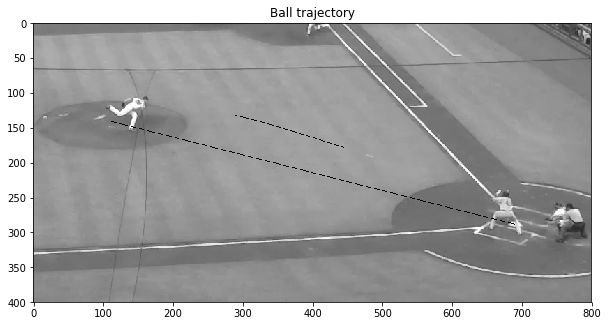

RELEASE FRAME AT  101.0 SPEED in mph 82.7115991051

trajectory [[522, 204], [562, 217], [603, 232]]
frames from release frame (using distance from center of base projected) 11.6837488228
trajectory [[522, 204], [562, 217], [603, 232], [643, 248]]
frames from release frame (using distance from center of base projected) 12.667005249


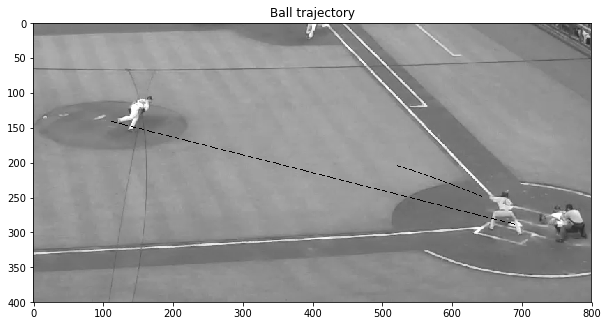

RELEASE FRAME AT  101.0 SPEED in mph 87.8171766179

trajectory [[741, 235], [724, 215], [706, 203]]
frames from release frame (using distance from center of base projected) 28.5191824936
trajectory [[741, 235], [724, 215], [706, 203], [686, 192]]
frames from release frame (using distance from center of base projected) 29.9376061167


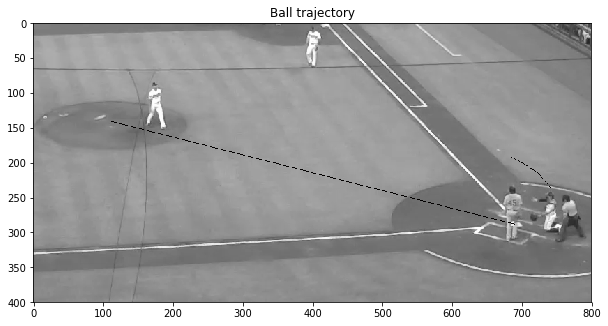

RELEASE FRAME AT  140.0 SPEED in mph 48.2096745786

trajectory [[649, 172], [630, 163], [612, 155]]
frames from release frame (using distance from center of base projected) 28.0391611699
trajectory [[649, 172], [630, 163], [612, 155]]
frames from release frame (using distance from center of base projected) 28.0391611699


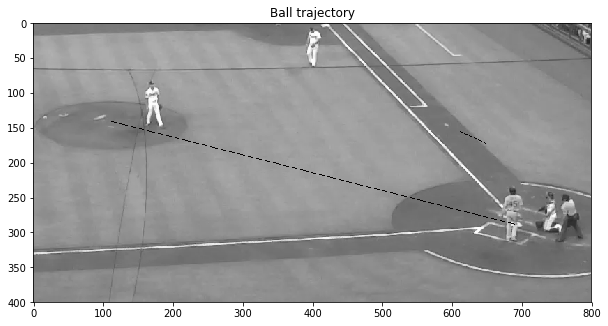

RELEASE FRAME AT  146.0 SPEED in mph 41.6469894404

------------------------------------------------------------------------
video: 490770-2065dfd4-7a7e-4889-a6a5-ee941aa2f62f.m4v
trajectory [[735, 223], [712, 213], [690, 204]]
frames from release frame (using distance from center of base projected) 27.6344608774
trajectory [[735, 223], [712, 213], [690, 204]]
frames from release frame (using distance from center of base projected) 27.6344608774


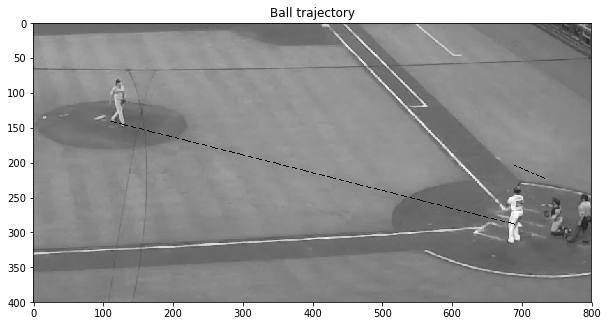

RELEASE FRAME AT  140.0 SPEED in mph 49.9598059392

trajectory [[644, 184], [623, 175], [600, 168]]
frames from release frame (using distance from center of base projected) 24.5340615243
trajectory [[644, 184], [623, 175], [600, 168], [576, 158], [557, 152]]
frames from release frame (using distance from center of base projected) 26.7681310765


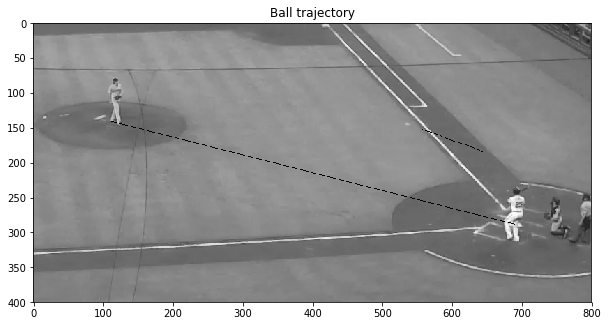

RELEASE FRAME AT  147.0 SPEED in mph 47.461594077

------------------------------------------------------------------------
video: 490770-20d18884-c48b-4a6f-9870-bdf54ece8321.m4v
trajectory [[152, 113], [197, 124], [241, 135]]
frames from release frame (using distance from center of base projected) 2.74215891553
trajectory [[152, 113], [197, 124], [241, 135], [287, 146], [333, 158], [380, 171], [427, 183]]
frames from release frame (using distance from center of base projected) 6.71927428819


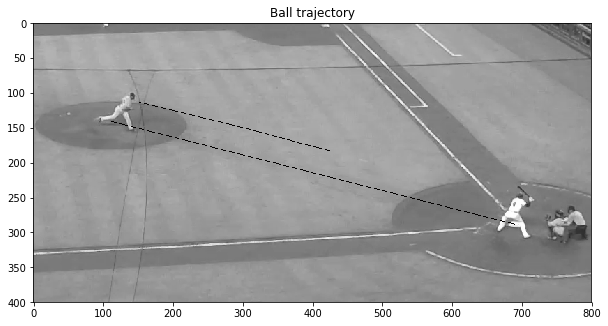

RELEASE FRAME AT  110.0 SPEED in mph 96.745871541

------------------------------------------------------------------------
video: 490770-26c36f4b-d646-47c3-b06d-a049a0d3828d.m4v
trajectory [[633, 239], [682, 254], [735, 269]]
frames from release frame (using distance from center of base projected) 11.9926295085
trajectory [[633, 239], [682, 254], [735, 269]]
frames from release frame (using distance from center of base projected) 11.9926295085


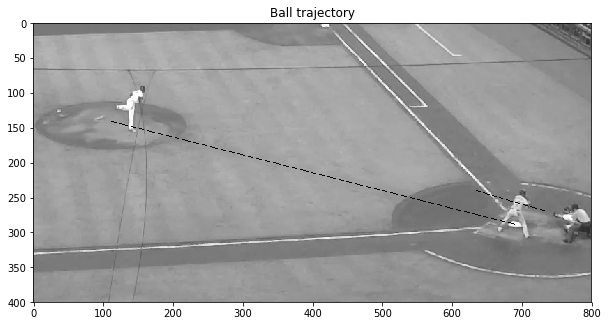

RELEASE FRAME AT  110.0 SPEED in mph 108.74274644

trajectory [[672, 181], [652, 171], [632, 161]]
frames from release frame (using distance from center of base projected) 26.806407803
trajectory [[672, 181], [652, 171], [632, 161], [612, 152], [593, 144], [574, 136]]
frames from release frame (using distance from center of base projected) 30.7075879235


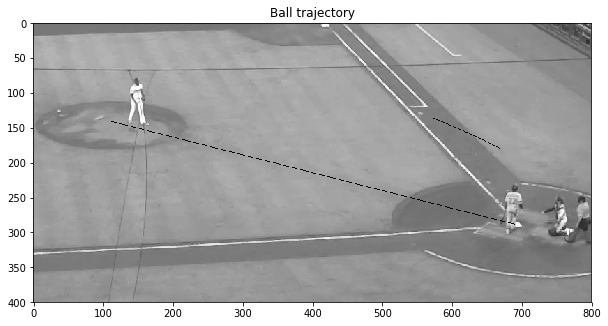

RELEASE FRAME AT  135.0 SPEED in mph 44.1344042331

------------------------------------------------------------------------
video: 490770-280bedf8-0c8b-42c3-aeb9-1b42ec473aa7.m4v
trajectory [[146, 113], [190, 122], [234, 132]]
frames from release frame (using distance from center of base projected) 2.6265812636
trajectory [[146, 113], [190, 122], [234, 132]]
frames from release frame (using distance from center of base projected) 2.6265812636


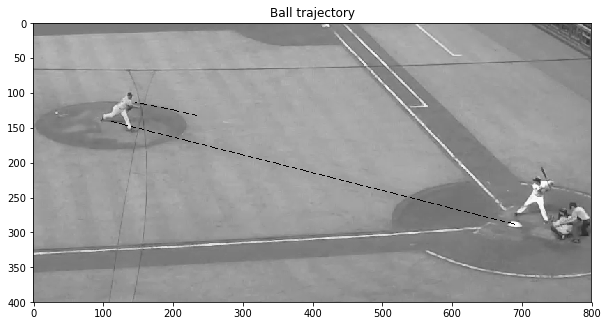

RELEASE FRAME AT  95.0 SPEED in mph 92.0792616419

trajectory [[323, 154], [369, 166], [415, 178]]
frames from release frame (using distance from center of base projected) 6.41419061104
trajectory [[323, 154], [369, 166], [415, 178], [461, 192], [508, 206], [555, 221], [603, 236], [652, 251]]
frames from release frame (using distance from center of base projected) 11.2817151223


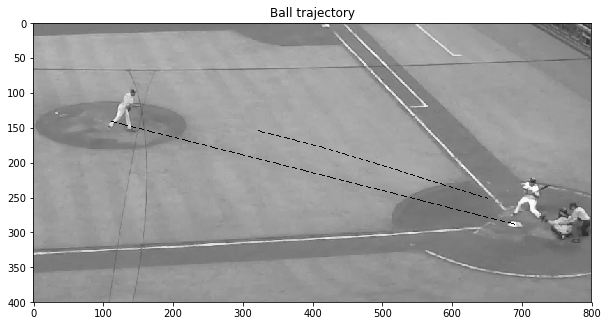

RELEASE FRAME AT  96.0 SPEED in mph 100.248354013

trajectory [[725, 224], [704, 213], [683, 203]]
frames from release frame (using distance from center of base projected) 28.2604878473
trajectory [[725, 224], [704, 213], [683, 203], [661, 192], [641, 182], [620, 172], [600, 164], [580, 155]]
frames from release frame (using distance from center of base projected) 33.8694793626


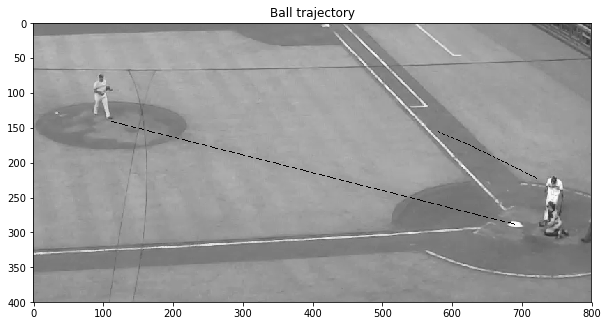

RELEASE FRAME AT  148.0 SPEED in mph 46.9446746186

------------------------------------------------------------------------
video: 490770-28b71b3e-cb07-4ad2-9ea2-beb68fa85e62.m4v
trajectory [[187, 115], [231, 126], [275, 139]]
frames from release frame (using distance from center of base projected) 3.50004849838
trajectory [[187, 115], [231, 126], [275, 139], [322, 151]]
frames from release frame (using distance from center of base projected) 4.4690205955


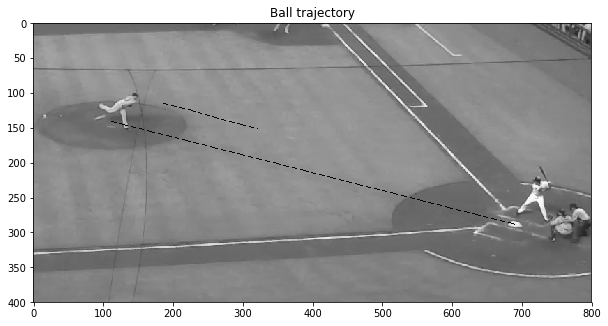

RELEASE FRAME AT  109.0 SPEED in mph 95.2787283733

trajectory [[463, 191], [510, 205], [559, 221]]
frames from release frame (using distance from center of base projected) 9.051608779
trajectory [[463, 191], [510, 205], [559, 221], [608, 236]]
frames from release frame (using distance from center of base projected) 10.0074378565


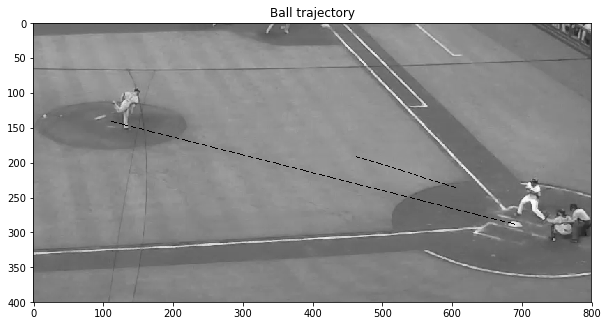

RELEASE FRAME AT  109.0 SPEED in mph 103.521386338

trajectory [[671, 206], [649, 195], [626, 185]]
frames from release frame (using distance from center of base projected) 24.541808673
trajectory [[671, 206], [649, 195], [626, 185], [604, 175]]
frames from release frame (using distance from center of base projected) 25.7470152819


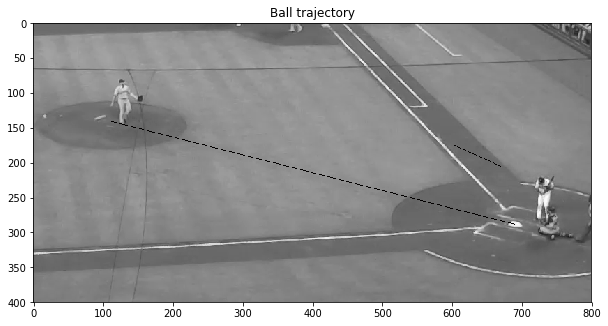

RELEASE FRAME AT  141.0 SPEED in mph 50.3472902838

------------------------------------------------------------------------
video: 490770-2e192582-a796-4e57-a1e5-2164414344ec.m4v
trajectory [[433, 174], [482, 186], [530, 199]]
frames from release frame (using distance from center of base projected) 8.41618501166
trajectory [[433, 174], [482, 186], [530, 199], [578, 211], [627, 225], [676, 238], [730, 254]]
frames from release frame (using distance from center of base projected) 12.2681188066


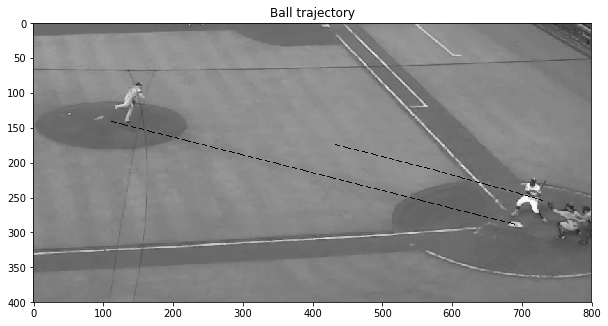

RELEASE FRAME AT  109.0 SPEED in mph 104.874168252

------------------------------------------------------------------------
video: 490770-2eed2f10-08e4-4377-afd0-939f1d51dbe3.m4v
trajectory [[506, 187], [551, 199], [595, 211]]
frames from release frame (using distance from center of base projected) 10.5772968604
trajectory [[506, 187], [551, 199], [595, 211], [639, 223], [685, 237], [731, 250]]
frames from release frame (using distance from center of base projected) 13.4590045499


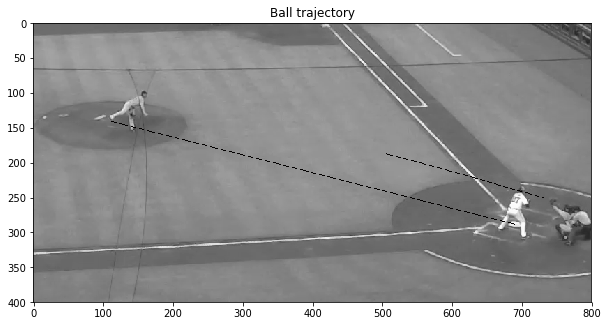

RELEASE FRAME AT  106.0 SPEED in mph 95.5928579383

trajectory [[770, 233], [717, 245], [763, 247]]
frames from release frame (using distance from center of base projected) 15.1992349223
trajectory [[770, 233], [717, 245], [763, 247], [719, 252]]
frames from release frame (using distance from center of base projected) 16.7383882342


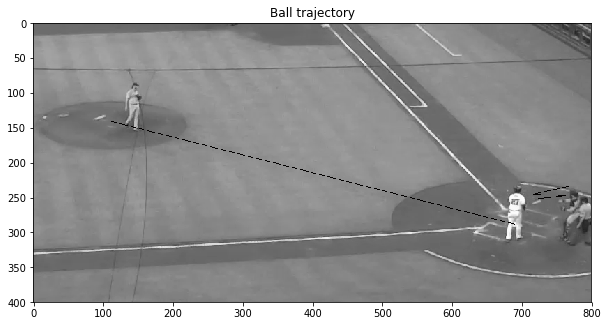

RELEASE FRAME AT  146.0 SPEED in mph 98.637348738

trajectory [[626, 159], [604, 154], [582, 146]]
frames from release frame (using distance from center of base projected) 23.9565875119
trajectory [[626, 159], [604, 154], [582, 146]]
frames from release frame (using distance from center of base projected) 23.9565875119


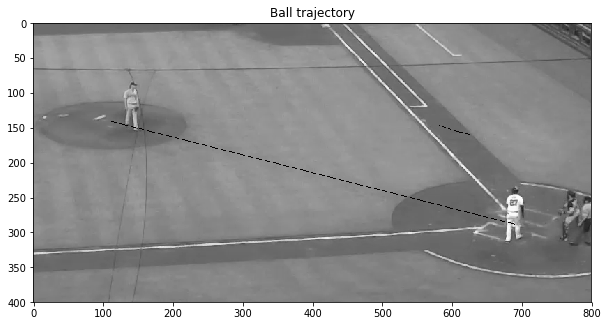

RELEASE FRAME AT  144.0 SPEED in mph 47.0151980877

------------------------------------------------------------------------
video: 490770-3071770f-8a6b-4585-a2f0-1ac435f28ffb.m4v
trajectory [[156, 101], [194, 109], [230, 118]]
frames from release frame (using distance from center of base projected) 2.91990031712
trajectory [[156, 101], [194, 109], [230, 118], [268, 128], [306, 138], [343, 148], [382, 159], [422, 171], [461, 183], [500, 195], [542, 209], [582, 224], [623, 238]]
frames from release frame (using distance from center of base projected) 12.8605615992


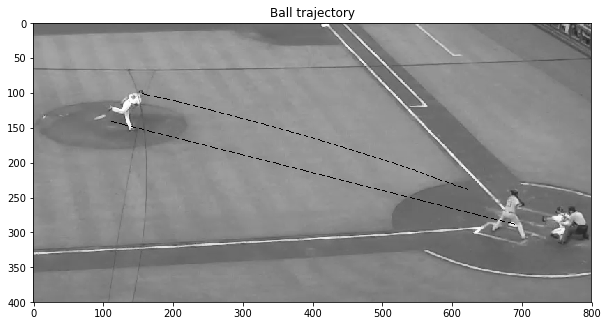

RELEASE FRAME AT  101.0 SPEED in mph 83.0222344289

trajectory [[756, 241], [743, 224], [724, 212]]
frames from release frame (using distance from center of base projected) 31.6726007063
trajectory [[756, 241], [743, 224], [724, 212], [704, 201], [686, 189]]
frames from release frame (using distance from center of base projected) 33.4758874371


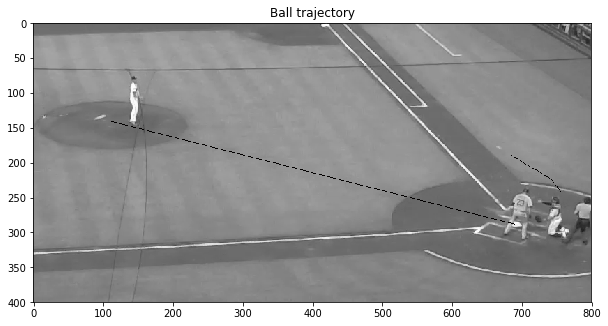

RELEASE FRAME AT  122.0 SPEED in mph 45.1696950675

trajectory [[612, 148], [595, 140], [577, 132]]
frames from release frame (using distance from center of base projected) 27.3802248813
trajectory [[612, 148], [595, 140], [577, 132], [560, 124], [542, 116]]
frames from release frame (using distance from center of base projected) 29.3802248813


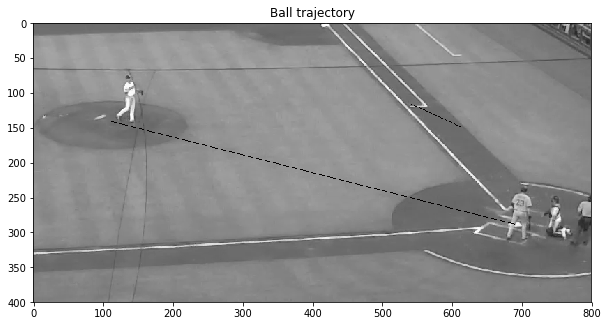

RELEASE FRAME AT  134.0 SPEED in mph 39.3606813771

------------------------------------------------------------------------
video: 490770-325a94ab-c6cf-41b4-8894-fcdf44c2870a.m4v
trajectory [[172, 109], [217, 121], [262, 135]]
frames from release frame (using distance from center of base projected) 3.11868221327
trajectory [[172, 109], [217, 121], [262, 135], [308, 148], [354, 161], [402, 175], [449, 190], [498, 204], [546, 219], [596, 235], [646, 251]]
frames from release frame (using distance from center of base projected) 11.0590412213


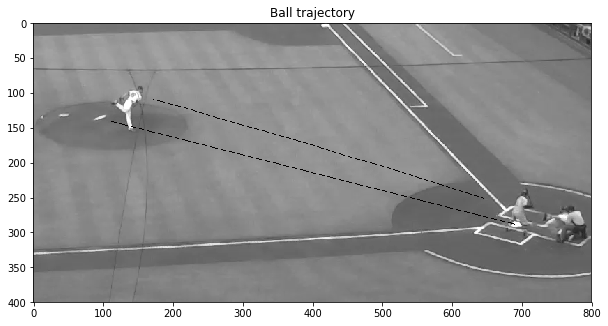

RELEASE FRAME AT  91.0 SPEED in mph 101.226269169

trajectory [[764, 234], [742, 221], [717, 210]]
frames from release frame (using distance from center of base projected) 26.8524643774
trajectory [[764, 234], [742, 221], [717, 210], [693, 201], [669, 191], [646, 183], [622, 174], [600, 167]]
frames from release frame (using distance from center of base projected) 32.8972262022


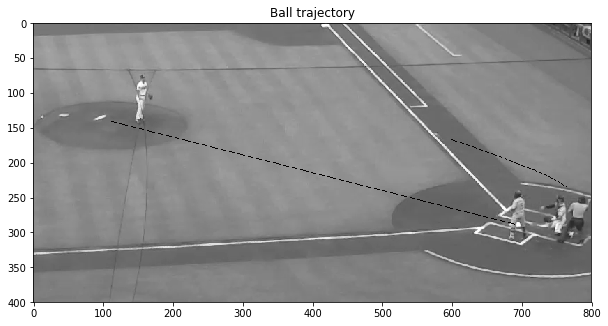

RELEASE FRAME AT  113.0 SPEED in mph 51.8871110409

------------------------------------------------------------------------
video: 490770-34172a92-9da2-4adc-b713-7bb19224b2c4.m4v
trajectory [[183, 120], [227, 128], [272, 139]]
frames from release frame (using distance from center of base projected) 3.4451654939
trajectory [[183, 120], [227, 128], [272, 139], [317, 148], [364, 159], [410, 171], [456, 184], [504, 197], [551, 209], [599, 224]]
frames from release frame (using distance from center of base projected) 10.3799372642


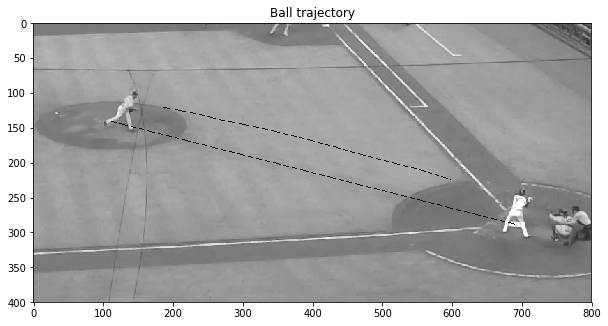

RELEASE FRAME AT  107.0 SPEED in mph 97.5169833439

trajectory [[769, 242], [750, 228], [728, 217]]
frames from release frame (using distance from center of base projected) 29.5432289504
trajectory [[769, 242], [750, 228], [728, 217], [707, 207], [684, 196], [663, 188], [641, 179], [620, 172], [599, 164], [577, 156]]
frames from release frame (using distance from center of base projected) 37.2836208598


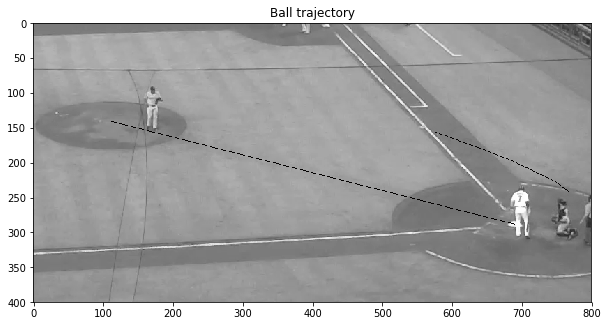

RELEASE FRAME AT  148.0 SPEED in mph 48.002619395

------------------------------------------------------------------------
video: 490770-377b386d-8176-4cdb-98ce-2646ffe829a1.m4v
trajectory [[175, 118], [216, 128], [258, 138]]
frames from release frame (using distance from center of base projected) 3.34797593141
trajectory [[175, 118], [216, 128], [258, 138], [302, 149], [346, 162], [390, 173], [433, 186], [478, 200], [523, 213], [568, 228], [614, 244], [660, 259], [705, 275]]
frames from release frame (using distance from center of base projected) 13.248353378


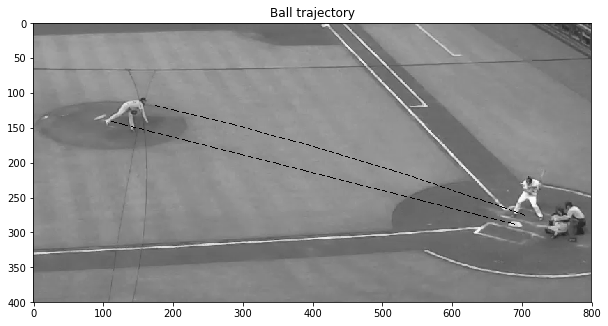

RELEASE FRAME AT  91.0 SPEED in mph 94.2844188777

trajectory [[701, 216], [675, 208], [650, 199]]
frames from release frame (using distance from center of base projected) 23.997465963
trajectory [[701, 216], [675, 208], [650, 199], [626, 188]]
frames from release frame (using distance from center of base projected) 25.1308217997


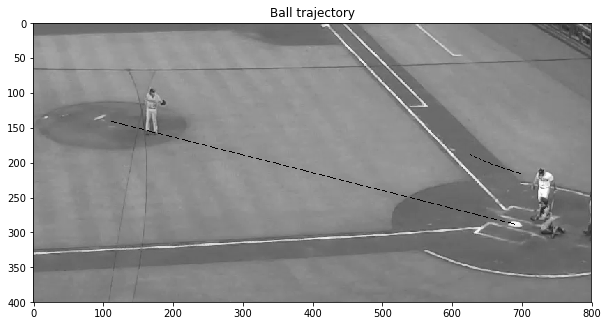

RELEASE FRAME AT  136.0 SPEED in mph 54.6643211684

trajectory [[577, 173], [553, 166], [529, 159]]
frames from release frame (using distance from center of base projected) 20.4263889577
trajectory [[577, 173], [553, 166], [529, 159], [505, 153], [482, 146]]
frames from release frame (using distance from center of base projected) 22.6539174456


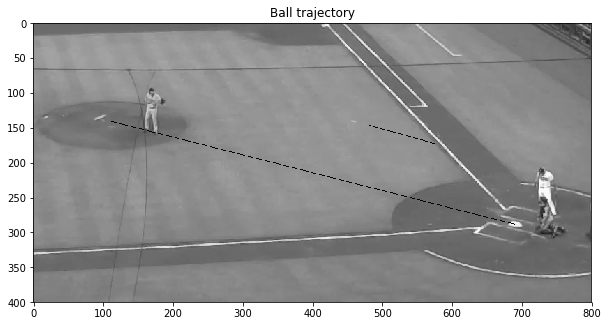

RELEASE FRAME AT  144.0 SPEED in mph 50.5126216906

------------------------------------------------------------------------
video: 490770-39792d6d-ecca-4814-9300-b0b8a388acc7.m4v
trajectory [[172, 114], [214, 123], [257, 134]]
frames from release frame (using distance from center of base projected) 3.22847849337
trajectory [[172, 114], [214, 123], [257, 134], [300, 143], [344, 154], [388, 165]]
frames from release frame (using distance from center of base projected) 6.20837335046


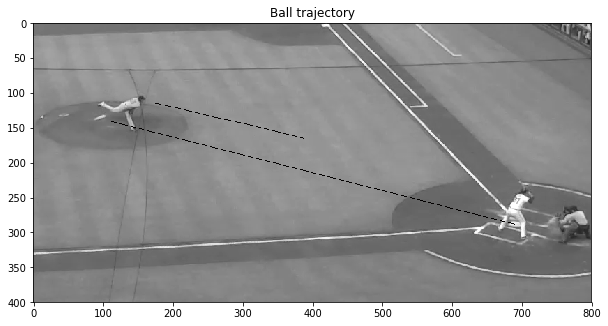

RELEASE FRAME AT  109.0 SPEED in mph 90.8092534396

trajectory [[480, 189], [526, 201], [574, 215]]
frames from release frame (using distance from center of base projected) 9.59953782195
trajectory [[480, 189], [526, 201], [574, 215], [621, 229], [668, 243]]
frames from release frame (using distance from center of base projected) 11.5784765719


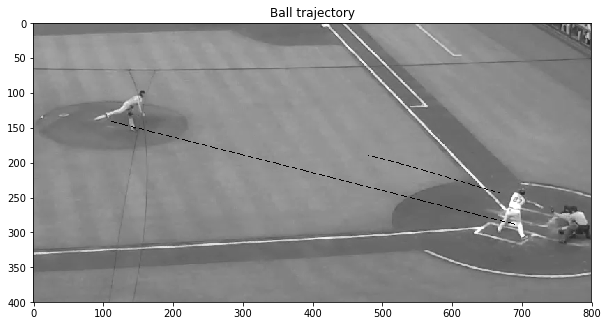

RELEASE FRAME AT  109.0 SPEED in mph 100.033467859

trajectory [[766, 236], [748, 223], [726, 214]]
frames from release frame (using distance from center of base projected) 30.6848186818
trajectory [[766, 236], [748, 223], [726, 214], [705, 205], [684, 195], [664, 188], [643, 180], [622, 173], [601, 165], [581, 159]]
frames from release frame (using distance from center of base projected) 38.4901162629


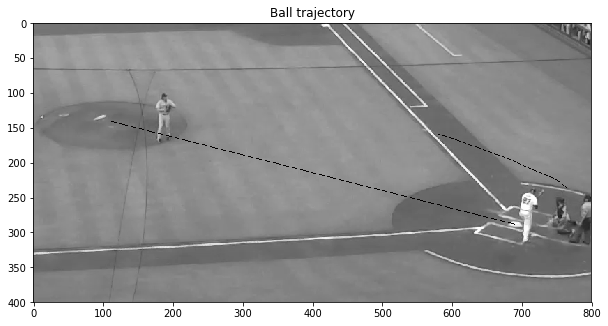

RELEASE FRAME AT  155.0 SPEED in mph 45.7342252642

------------------------------------------------------------------------
video: 490770-399d82f0-09f9-4465-9742-036a23d4007c.m4v
trajectory [[168, 107], [212, 119], [258, 131]]
frames from release frame (using distance from center of base projected) 3.03149284861
trajectory [[168, 107], [212, 119], [258, 131], [303, 143], [350, 156], [398, 170]]
frames from release frame (using distance from center of base projected) 6.00719573392


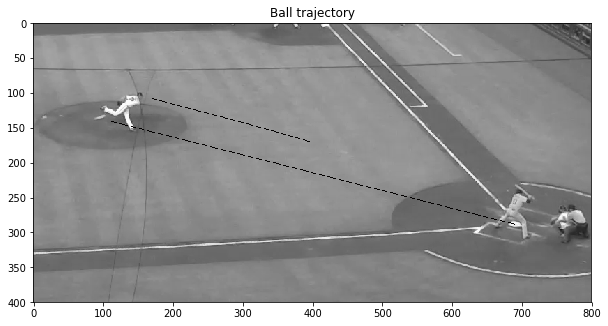

RELEASE FRAME AT  88.0 SPEED in mph 97.5615038812

trajectory [[492, 200], [539, 214], [588, 230]]
frames from release frame (using distance from center of base projected) 9.65456703645
trajectory [[492, 200], [539, 214], [588, 230], [637, 245]]
frames from release frame (using distance from center of base projected) 10.6066192138


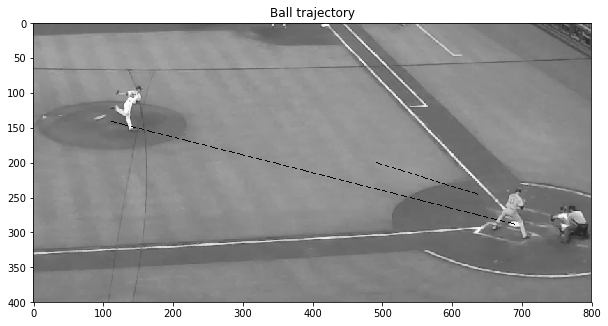

RELEASE FRAME AT  88.0 SPEED in mph 103.521386338

trajectory [[767, 251], [758, 246], [747, 243]]
frames from release frame (using distance from center of base projected) 63.209778283
trajectory [[767, 251], [758, 246], [747, 243]]
frames from release frame (using distance from center of base projected) 63.209778283


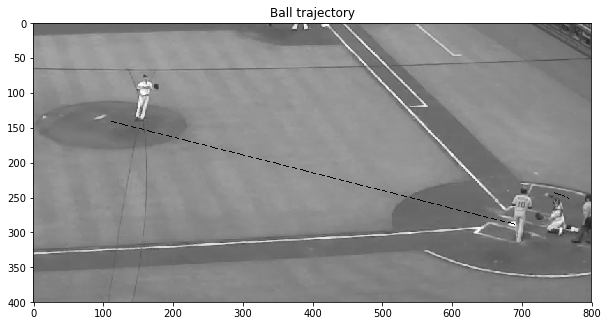

RELEASE FRAME AT  90.0 SPEED in mph 22.1905008471

trajectory [[676, 194], [654, 184], [632, 176]]
frames from release frame (using distance from center of base projected) 25.6162853786
trajectory [[676, 194], [654, 184], [632, 176], [610, 167], [588, 159]]
frames from release frame (using distance from center of base projected) 27.7150734774


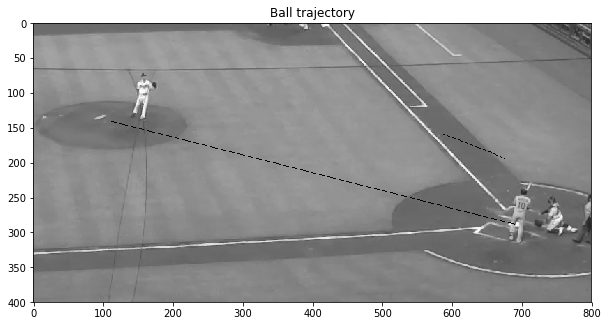

RELEASE FRAME AT  132.0 SPEED in mph 48.4540542461

------------------------------------------------------------------------
video: 490770-3b5a5d69-0b56-4184-88ce-06ce8d6ccc9e.m4v
trajectory [[180, 114], [223, 123], [263, 133]]
frames from release frame (using distance from center of base projected) 3.4418998732
trajectory [[180, 114], [223, 123], [263, 133], [304, 143], [347, 154], [391, 164]]
frames from release frame (using distance from center of base projected) 6.41554199726


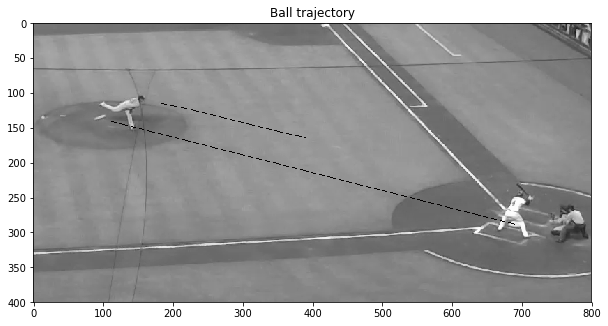

RELEASE FRAME AT  112.0 SPEED in mph 88.7201174135

trajectory [[569, 216], [612, 228], [659, 243]]
frames from release frame (using distance from center of base projected) 11.8647943257
trajectory [[569, 216], [612, 228], [659, 243]]
frames from release frame (using distance from center of base projected) 11.8647943257


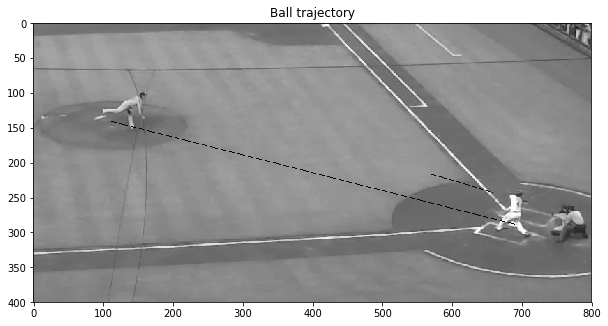

RELEASE FRAME AT  112.0 SPEED in mph 96.114466068

trajectory [[777, 249], [766, 236], [748, 223]]
frames from release frame (using distance from center of base projected) 36.3201508627
trajectory [[777, 249], [766, 236], [748, 223], [729, 213]]
frames from release frame (using distance from center of base projected) 36.2717202535


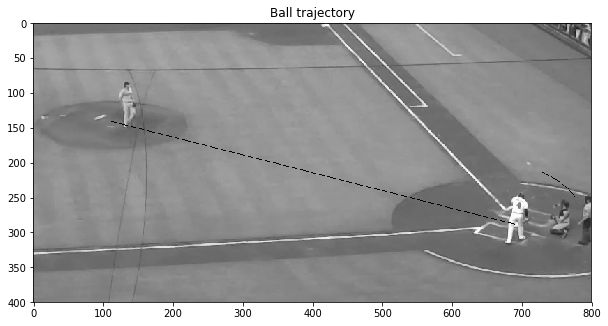

RELEASE FRAME AT  207.0 SPEED in mph 41.3890118475

trajectory [[621, 153], [602, 145], [584, 136]]
frames from release frame (using distance from center of base projected) 26.4647469507
trajectory [[621, 153], [602, 145], [584, 136]]
frames from release frame (using distance from center of base projected) 26.4647469507


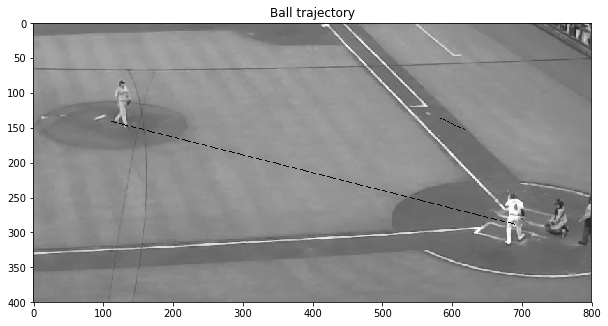

RELEASE FRAME AT  225.0 SPEED in mph 41.6660410857

------------------------------------------------------------------------
video: 490770-3c1a0b14-2651-42e0-8049-b5a7538f6fe7.m4v
trajectory [[336, 141], [382, 154], [425, 167]]
frames from release frame (using distance from center of base projected) 6.72867343386
trajectory [[336, 141], [382, 154], [425, 167], [471, 182], [517, 196], [564, 212], [610, 228], [658, 244]]
frames from release frame (using distance from center of base projected) 11.5384023118


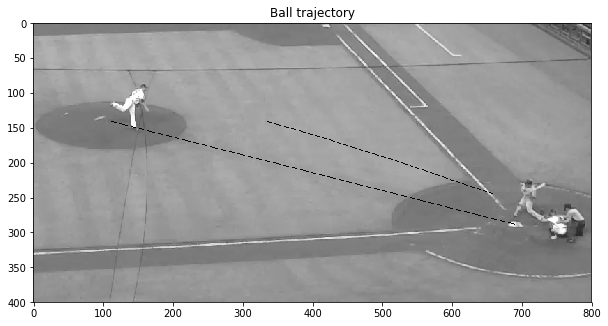

RELEASE FRAME AT  112.0 SPEED in mph 98.8069303124

trajectory [[697, 205], [677, 195], [658, 184]]
frames from release frame (using distance from center of base projected) 28.3948360004
trajectory [[697, 205], [677, 195], [658, 184], [640, 174], [620, 165], [601, 156], [583, 147], [564, 140]]
frames from release frame (using distance from center of base projected) 34.6177764386


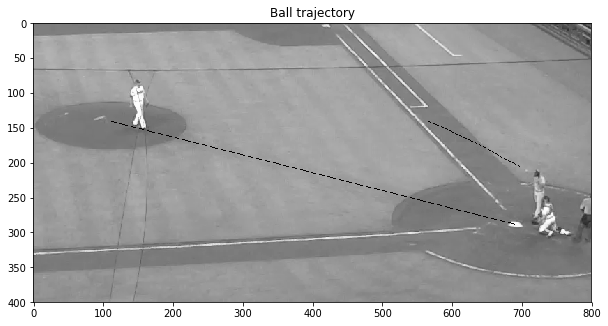

RELEASE FRAME AT  139.0 SPEED in mph 43.3154149766

------------------------------------------------------------------------
video: 490770-3c687faa-deb4-4232-ad2a-036ecff2c739.m4v
trajectory [[289, 148], [333, 159], [378, 172]]
frames from release frame (using distance from center of base projected) 5.80544864993
trajectory [[289, 148], [333, 159], [378, 172], [423, 186], [466, 199], [514, 213], [560, 228], [608, 243], [655, 258], [701, 274]]
frames from release frame (using distance from center of base projected) 12.6634462494


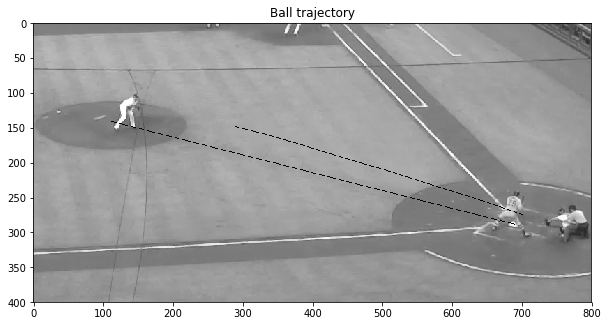

RELEASE FRAME AT  96.0 SPEED in mph 97.9444672443

trajectory [[679, 200], [655, 191], [632, 182]]
frames from release frame (using distance from center of base projected) 24.4981688744
trajectory [[679, 200], [655, 191], [632, 182], [609, 173]]
frames from release frame (using distance from center of base projected) 25.638179493


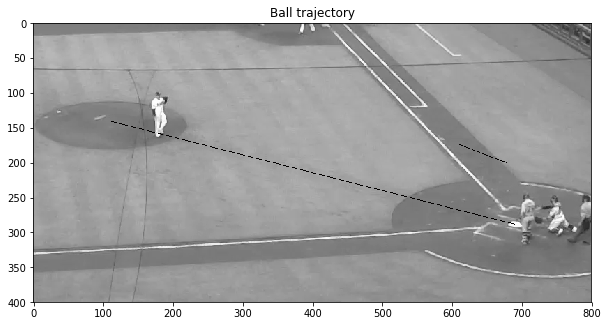

RELEASE FRAME AT  136.0 SPEED in mph 51.1556913882

trajectory [[564, 159], [541, 152], [518, 146]]
frames from release frame (using distance from center of base projected) 20.5981683619
trajectory [[564, 159], [541, 152], [518, 146]]
frames from release frame (using distance from center of base projected) 20.5981683619


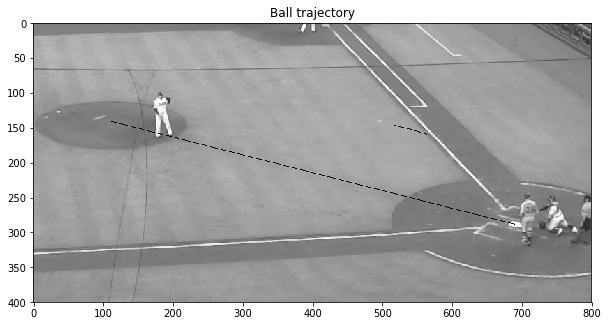

RELEASE FRAME AT  145.0 SPEED in mph 48.8979679691

------------------------------------------------------------------------
video: 490770-3cbe6f30-6f59-4b5c-a6e3-ffb5e8b0e30d.m4v
trajectory [[155, 103], [199, 113], [244, 124]]
frames from release frame (using distance from center of base projected) 2.75354227827
trajectory [[155, 103], [199, 113], [244, 124], [290, 136], [337, 146], [384, 158], [431, 171], [479, 182], [527, 195], [577, 209], [624, 222], [676, 236], [728, 250]]
frames from release frame (using distance from center of base projected) 12.6987867506


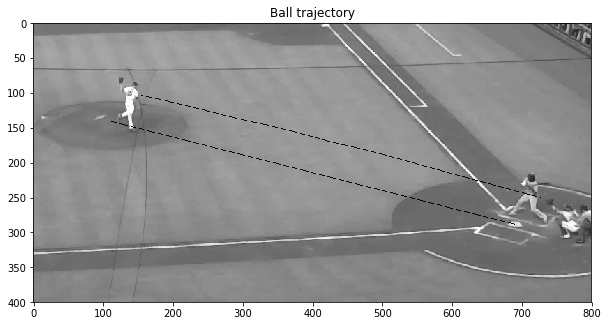

RELEASE FRAME AT  111.0 SPEED in mph 100.853767636

trajectory [[702, 205], [683, 195], [663, 185]]
frames from release frame (using distance from center of base projected) 28.9071089876
trajectory [[702, 205], [683, 195], [663, 185], [644, 175], [624, 167], [606, 157], [585, 151], [568, 143]]
frames from release frame (using distance from center of base projected) 34.8789001204


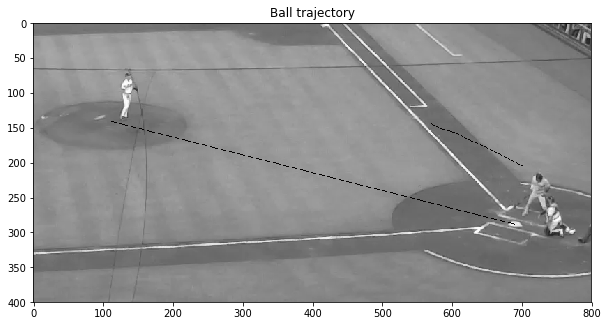

RELEASE FRAME AT  139.0 SPEED in mph 43.2651637417

------------------------------------------------------------------------
video: 490770-3d69a818-568e-4eef-9d63-24687477e7ee.m4v
trajectory [[410, 172], [450, 184], [490, 196]]
frames from release frame (using distance from center of base projected) 9.15011399579
trajectory [[410, 172], [450, 184], [490, 196]]
frames from release frame (using distance from center of base projected) 9.15011399579


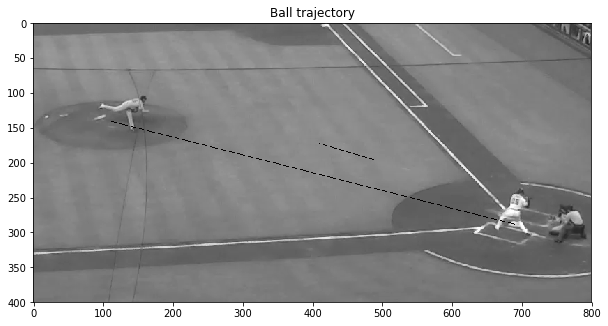

RELEASE FRAME AT  100.0 SPEED in mph 85.4206668395

trajectory [[760, 241], [752, 251], [748, 260]]
frames from release frame (using distance from center of base projected) 59.8051478432
trajectory [[760, 241], [752, 251], [748, 260]]
frames from release frame (using distance from center of base projected) 59.8051478432


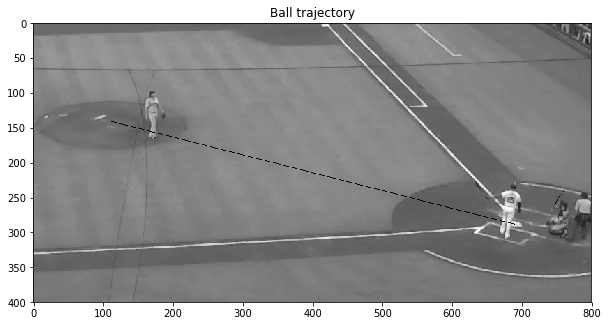

RELEASE FRAME AT  98.0 SPEED in mph 23.169988877

trajectory [[659, 190], [638, 183], [617, 175]]
frames from release frame (using distance from center of base projected) 26.4043759781
trajectory [[659, 190], [638, 183], [617, 175], [598, 167]]
frames from release frame (using distance from center of base projected) 28.0361698079


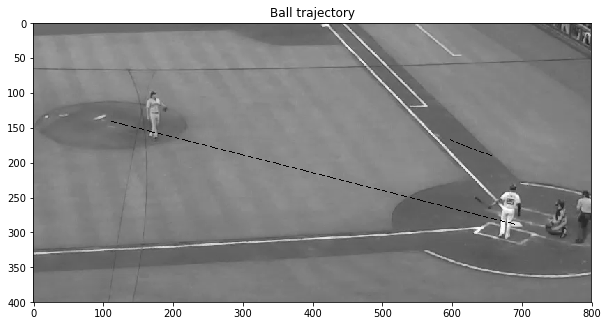

RELEASE FRAME AT  136.0 SPEED in mph 44.4706768708

------------------------------------------------------------------------
video: 490770-3ee905e0-03dd-4774-b796-9bdc46ed124b.m4v
trajectory [[482, 195], [531, 211], [579, 225]]
frames from release frame (using distance from center of base projected) 9.36707396484
trajectory [[482, 195], [531, 211], [579, 225], [628, 241], [674, 256]]
frames from release frame (using distance from center of base projected) 11.4261681465


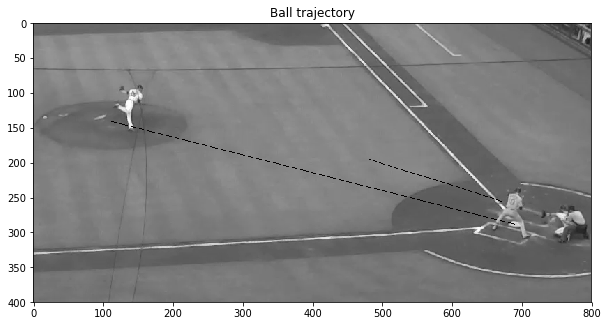

RELEASE FRAME AT  107.0 SPEED in mph 103.027510042

trajectory [[625, 160], [604, 152], [586, 143]]
frames from release frame (using distance from center of base projected) 25.6616348231
trajectory [[625, 160], [604, 152], [586, 143], [568, 137], [551, 132]]
frames from release frame (using distance from center of base projected) 29.4232214342


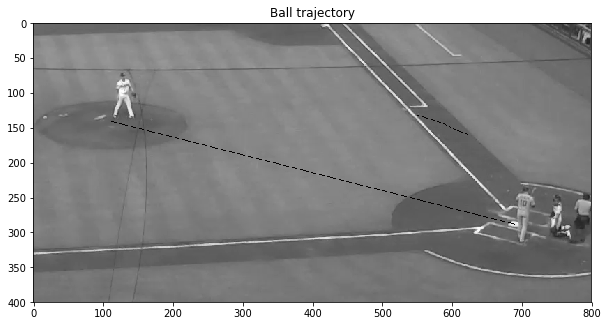

RELEASE FRAME AT  139.0 SPEED in mph 40.5462818942

------------------------------------------------------------------------
video: 490770-410fe0f1-89f6-41fb-bd18-e1653d256760.m4v
trajectory [[157, 103], [201, 114], [243, 123]]
frames from release frame (using distance from center of base projected) 2.82422083886
trajectory [[157, 103], [201, 114], [243, 123], [290, 135], [336, 146]]
frames from release frame (using distance from center of base projected) 4.79065861935


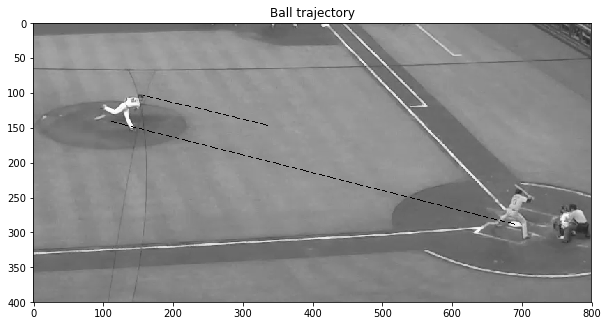

RELEASE FRAME AT  108.0 SPEED in mph 94.1483054041

trajectory [[521, 194], [569, 207], [616, 221]]
frames from release frame (using distance from center of base projected) 10.3343199891
trajectory [[521, 194], [569, 207], [616, 221], [665, 236]]
frames from release frame (using distance from center of base projected) 11.2310134253


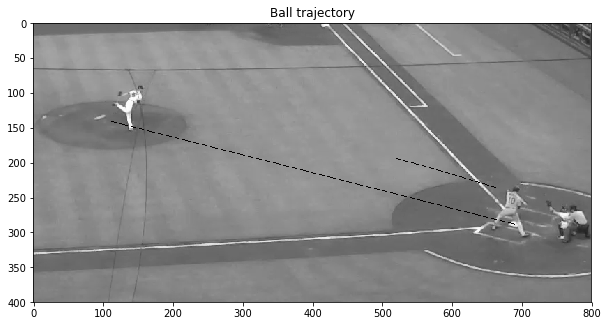

RELEASE FRAME AT  109.0 SPEED in mph 102.282639733

trajectory [[752, 244], [732, 227], [709, 215]]
frames from release frame (using distance from center of base projected) 26.8234508097
trajectory [[752, 244], [732, 227], [709, 215], [687, 205], [665, 195], [643, 185], [622, 176], [600, 168]]
frames from release frame (using distance from center of base projected) 33.5257207458


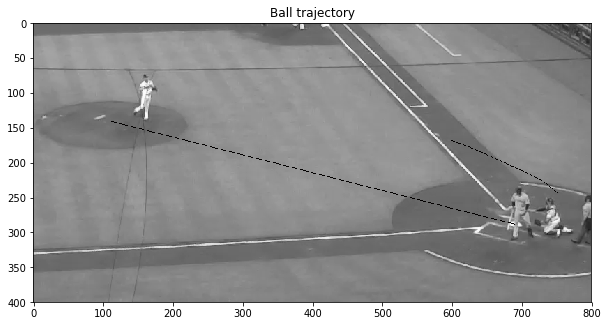

RELEASE FRAME AT  142.0 SPEED in mph 49.951753958

------------------------------------------------------------------------
video: 490770-4313b6eb-6fd9-40a8-92c7-70e8dffe1b5a.m4v
trajectory [[157, 105], [196, 114], [238, 125]]
frames from release frame (using distance from center of base projected) 2.88413935666
trajectory [[157, 105], [196, 114], [238, 125], [278, 135], [321, 146], [362, 158], [405, 170], [449, 184], [493, 197], [537, 211], [581, 225], [628, 240], [672, 256], [720, 272]]
frames from release frame (using distance from center of base projected) 13.8161224655


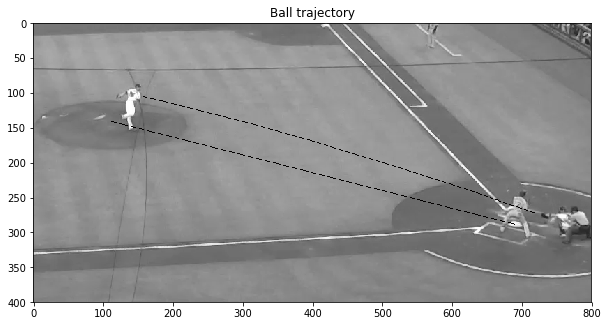

RELEASE FRAME AT  99.0 SPEED in mph 92.4501510456

trajectory [[744, 231], [721, 217], [701, 205]]
frames from release frame (using distance from center of base projected) 27.3460627373
trajectory [[744, 231], [721, 217], [701, 205], [680, 196], [658, 184], [639, 176], [617, 165], [596, 157], [576, 148]]
frames from release frame (using distance from center of base projected) 35.1312664857


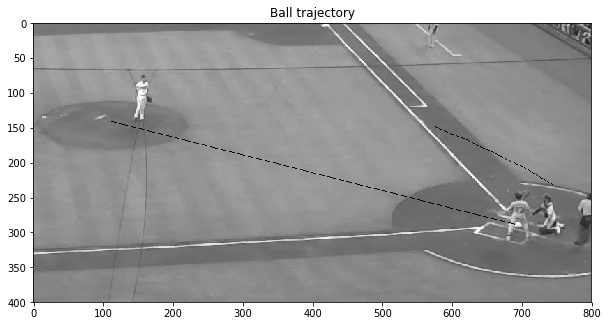

RELEASE FRAME AT  132.0 SPEED in mph 48.010147713

------------------------------------------------------------------------
video: 490770-43bb2a80-6528-43f7-bc08-68bececf5723.m4v
trajectory [[404, 157], [442, 170], [482, 183]]
frames from release frame (using distance from center of base projected) 9.03160443131
trajectory [[404, 157], [442, 170], [482, 183], [522, 197], [561, 212], [601, 228], [640, 242], [680, 259]]
frames from release frame (using distance from center of base projected) 13.8741656858


KeyboardInterrupt: 

In [144]:
path = "/Volumes/Nina Backup/videos/atl/2017-05-22/side view/"
l = os.listdir(path)
for BASE in l[30:]:
    if BASE[-4:]!=".m4v":
        continue
    print("------------------------------------------------------------------------")
    print("video:", BASE)
    frame_indizes, location, candidates_per_frame, first_move_frame = detect_ball(path+BASE, joints_array = None, plotting=False, min_area=30) #400
    #print(" RELEASE FRAME FOUND", first_move_frame)
    #if first_move_frame ==0:
     #   print("NO BALL TRAJECTORY FOUND")

#example ="#9 RHP Ryan King (2)" # #9 RHP Ryan King (2) #9 RHP Ryan King # #48 RHP Tom Flippin # 8 RHP Cole Johnson #15 Brandon Coborn # #10 Matt Glomb #26 RHP Tim Willites" (willites camera moves) #00 RHP Devin Smith
#BASE = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"+example+".mp4" #"data/Matt_Blais/" # für batter: pic davor, 03 streichen und (int(idx+1))
#joints_path = "/Volumes/Nina Backup/high_quality_outputs/"+example+".json"

# First Movement testing

In [ ]:
import ast
#joints_path = "/Volumes/Nina Backup/Nina's Pitch/40mph_1us_1.2f_170fps_40m_sun.json"
path = "/Volumes/Nina Backup/CENTERFIELD bsp videos/"
csv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/csvs/csv_gameplay.csv", delimiter = ";")
detected_first_move = []
label_first_move = []
label_release_frame =[]
j = 0
for bsp in os.listdir(path):
    if bsp[-4:]!=".mp4":
        continue
    BASE = path+ bsp # "/Volumes/Nina Backup/CENTERFIELD bsp videos/3d69a818-568e-4eef-9d63-24687477e7ee.mp4" # minarea 50
    print(bsp)
    joints_path = "/Volumes/Nina Backup/outputs/new_videos/cf/490770_"+ bsp[:-4] + "_pitcher.json" #3d69a818-568e-4eef-9d63-24687477e7ee_pitcher.json"
    if not os.path.exists(joints_path):
        print("file existiert nicht", joints_path)
        continue
    joints = from_json(joints_path)[:,:12,:]
    print(joints.shape)
    
    for i in open(BASE+".dat").readlines():
        datContent=ast.literal_eval(i)
    label_release_frame.append(datContent["pitch_frame_index"])
    label_first_move.append(datContent["first_movement_frame_index"])
    assert dic["label"][j] == label_first_move[-1]
    #if dic["position"][j]!= "Windup":
     #   j+=1
    #  continue
    print(dic["position"][j])
    j+=1
    #for name in ["40mph_1us_1.2f_170fps_40m_sun.avi","40mph_10us_6f_100fps_40m_cloudy.avi", "40mph_10us_11f_100fps_noisy.avi"]:
    #    frame_indizes, location, candidates_per_frame = detect_ball("/Volumes/Nina Backup/Nina's Pitch/"+name, joints_array=None)
    #import sys
    #sys.exit()
    frame_indizes, location, candidates_per_frame, first_move_frame = detect_ball(BASE, joints_array = joints, plotting=False, min_area=50) #400
    detected_first_move.append(first_move_frame)
    
    print("detected", detected_first_move[-1], "label", label_first_move[-1])
    
    
## FIRST MOVEMENT QUALITATIVE EVALUATION:
"""
        if first_move_found and joints_array is not None:
            if first_move_frame+2 >= t:
                print(first_move_frame, t)
                images = np.roll(np.array(images), -1, axis=0)
                images[-1] = frame
                t+=1
                continue
            else:
                diff = t-first_move_frame
                try:
                    show_frames = [images[-diff], images[-diff+1], images[-diff+2]]
                except IndexError:
                    print("PROBLEM: NOT ENOUGH FRAMES SAVED")
                    show_frames = [images[0], images[1], images[2]]
                    diff = 10
                fig = plt.figure(figsize=(10, 5))
                for ind, i in enumerate(show_frames):
                    ax = fig.add_subplot(1,len(show_frames),ind+1)
                    plt.imshow(i[100:400, 200:600])
                    plt.title("frame "+str(t-diff+ind))
                    plt.grid(False)
                    plt.axis('off')
                    plt.gray()
                plt.tight_layout()
                plt.show()
                plt.savefig("qualitative_first_move_3_refined/"+folder.split("/")[-1][:-4]+".png")
                break
"""

### ONLY DETECTION

In [ ]:
def polyarea_bbox(bbox):
    x = bbox[:,0]
    y = bbox[:,1]
    # print("Pearson", stats.pearsonr(x,y))
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def poly_factor(bbox):
    x = bbox[:,0]
    y = bbox[:,1]
    # print("Pearson", stats.pearsonr(x,y))
    area = 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
    length = np.linalg.norm(bbox[0,:2]-bbox[2,:2])
    print(area, length)
    return length/(area+0.0000001)

def overlap(box1, box2):
    if box1[0]> box2[2] or box2[0]>box1[2] or box1[1]>box2[3] or box2[1]>box1[3]:
        return False
    else: return True

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

out = np.array([[1098, 867, 1139, 905], [1074, 870, 1114, 908], [1050, 873, 1089, 911]])
x = out[:,[0, 2]].flatten()
y = out[:,[1,3]].flatten()
plt.scatter(x,y)
plt.show()
print(PolyArea(x,y))
print(np.linalg.norm(out[0,:2]-out[2,:2]))
print(overlap([1113, 617, 1146, 645], [1014, 655, 1047, 672]))

# first movement evaluation

### open json file with all results and csv with standard deviations

In [15]:
import pandas as pd
with open("all_first_move_tests.json", "r") as infile:
    dic = json.load(infile)
print(dic.keys())
df = pd.read_csv("first_move_evaluation.csv")
print(df.columns.tolist())
print(df["Unnamed: 0"])

dict_keys(['label', 'every_4', 'every_2', 'release', 'every_5', '3_refined_nograd', '3_refined', 'every_3', 'position'])
['Unnamed: 0', 'Unnamed: 0.1', 'every_2', 'every_3', 'every_4', 'every_5', 'label', 'every_3_refined']
0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64


### save recent output in dictionary

In [ ]:
a = detected_first_move.copy()
b = label_release_frame.copy()[:-1]
c = label_first_move.copy()
print(len(a),len(b),len(c))
assert(c==dic["label"])
d = np.array([a,b,c])
print(d.shape)

np.save("first_move_outputs_every_3_ref_without_gradient.npy", a)

dic["3_refined_nograd"]= np.array(a).astype(np.float32).tolist()
with open("all_first_move_tests.json", "w") as outfile:
    json.dump(dic, outfile)

### histograms of dictionary

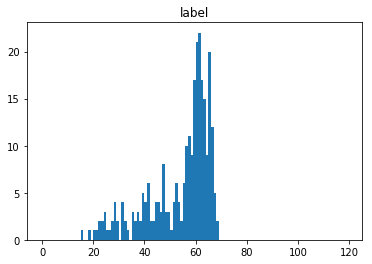

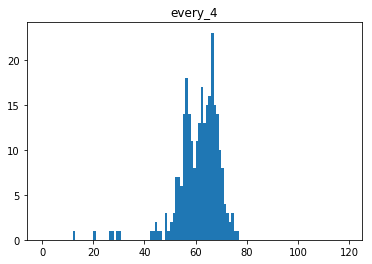

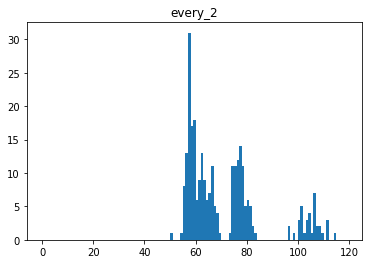

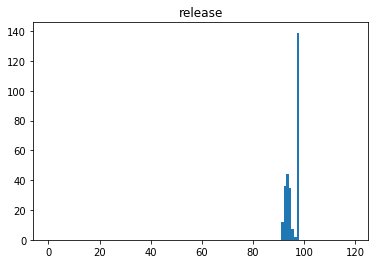

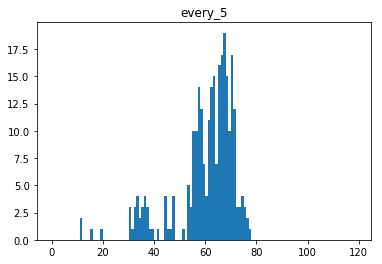

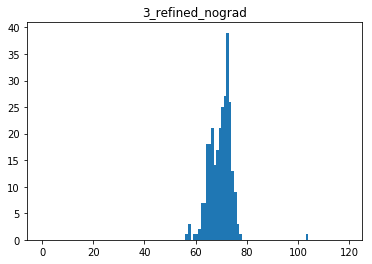

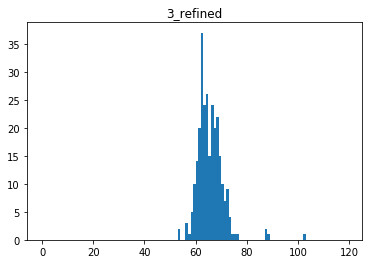

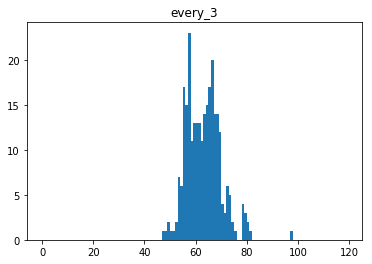

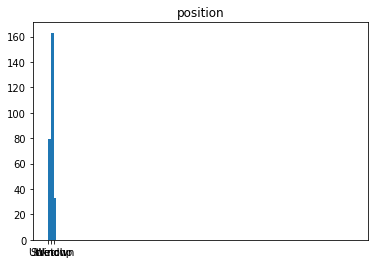

In [16]:
for i in list(dic.keys()):
    plt.hist(dic[i], bins=np.arange(120))
    plt.title(i)
    plt.show()

### form csv with standard deviations and outliers

In [ ]:
print(df)
new_column = "3_refined_nograd"
new_column_values = dic[new_column]
a = np.round(np.mean(new_column_values),3)
b = np.round(np.std(new_column_values),3)
c = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 3*b)/275
d = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 2*b)/275
e = np.sum(np.absolute(new_column_values-np.mean(new_column_values)) > 1*b)/275
l = [e,d,c,b,a]
print(l)
d = pd.Series(l)
df["every_3_refined"]=d
print(df)
df.to_csv("first_move_evaluation.csv")

In [ ]:
# dic = {"every_2":[], "every_3":[], "every_4":[], "every_5":[], "label":[]}
i=1
for d in outputs:
    i+=1
    rel_detect = np.array(d[1]-d[0])
    std = np.std(rel_detect)
    more_than_2std = np.absolute(rel_detect-np.mean(rel_detect))> 3*std
    #print(more_than_2std)
    print(np.sum(more_than_2std))
    dic["every_%d"%i].append(np.mean(rel_detect))

d = outputs[1]
rel_lab = np.array(d[1]-d[2])
std_2 = np.std(rel_lab)
more_than_2std_2 = np.absolute(rel_lab-np.mean(rel_lab))> 3*std_2
print(np.sum(more_than_2std_2))
dic["label"].append(np.mean(rel_lab))

print(dic)

In [ ]:

for key in dic.keys():
    for i in range(len(dic[key])):
        dic[key][i] = round(dic[key][i], 3)
print(dic)
df = pd.DataFrame.from_dict(dic)
df = df.rename(index = {0: "percentage >1*std", 1: "percentage >2*std", 2: "percentage >3*std", 3: "std", 4: "mean"}) 
df.to_csv("first_move_evaluation.csv")
#with open("dic_with_first_move_evaluation.json", "w") as outfile:
 #   json.dump(dic, outfile)

### For position and gradient retrieval

In [ ]:
arr = np.array(outputs[2])
j=0
#old = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/cf_data_cut.csv")
cf_list = old["Pitching Position (P)"].values
print(cf_list)
position  = []
cf_play_list = old["play_id"].values.tolist()
refined = []
for bsp in (os.listdir(path)):
    if bsp[-4:]!=".mp4":
        continue
    BASE = path+ bsp # "/Volumes/Nina Backup/CENTERFIELD bsp videos/3d69a818-568e-4eef-9d63-24687477e7ee.mp4" # minarea 50
    # print(bsp)
    joints_path = "/Volumes/Nina Backup/outputs/new_videos/cf/490770_"+ bsp[:-4] + "_pitcher.json" #3d69a818-568e-4eef-9d63-24687477e7ee_pitcher.json"
    if not os.path.exists(joints_path):
        print("file existiert nicht", joints_path)
        continue
    joints = from_json(joints_path)[:,:12,:]
    # print(joints.shape)
    
    #print(bsp, cf_play_list)
    if bsp[:-4] in cf_play_list:
        position.append(cf_list[cf_play_list.index(bsp[:-4])])
        # print(pos)
    else: 
        position.append("Unknown")
    continue
    
    for i in open(BASE+".dat").readlines():
        datContent=ast.literal_eval(i)
    rel_frame = datContent["pitch_frame_index"]
    label_first_move = datContent["first_movement_frame_index"]

    assert(rel_frame == arr[1,j])
    assert(label_first_move == arr[2,j])
    first_move_frame = arr[0,j]
    range_joints = joints[first_move_frame -10: first_move_frame +10]
    grad = np.gradient(range_joints, axis = 0)
    plt.plot(grad[:,:,1])
    #plt.show()
    mean_gradient = np.mean(grad[:, [7,8,10,11],1], axis = 1)
    plt.plot(mean_gradient, c = "black")
    plt.show()
    print("previous", first_move_frame, "new", first_move_frame-10+np.argmin(mean_gradient))
    refined.append(first_move_frame-10+np.argmin(mean_gradient))
    j+=1
    
print(position, len(position))

### plot comparisons

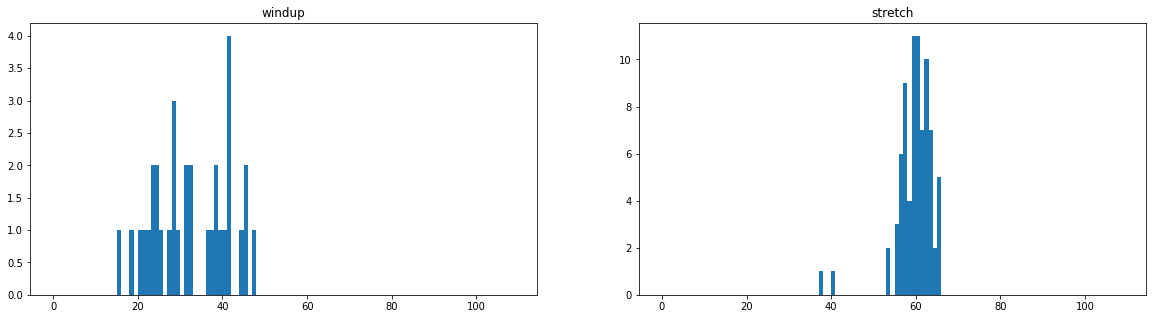

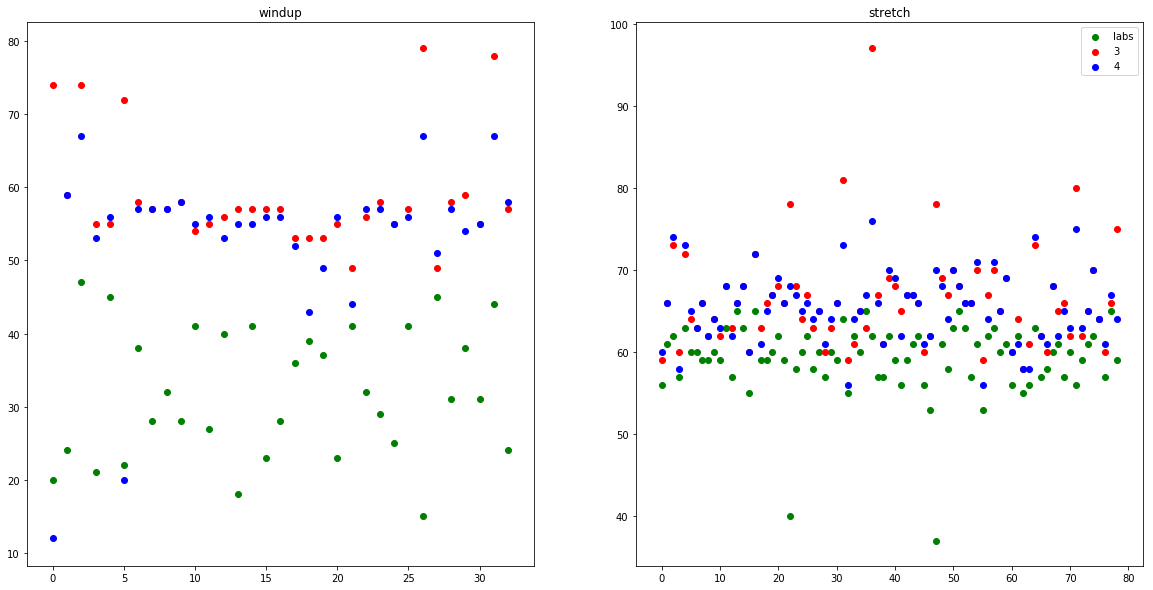

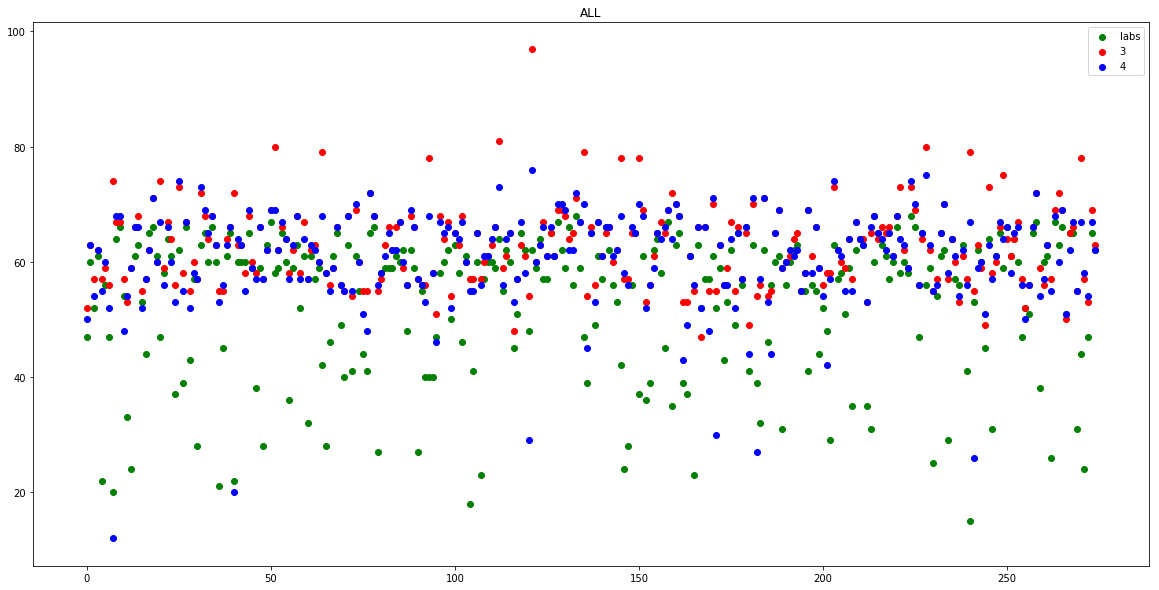

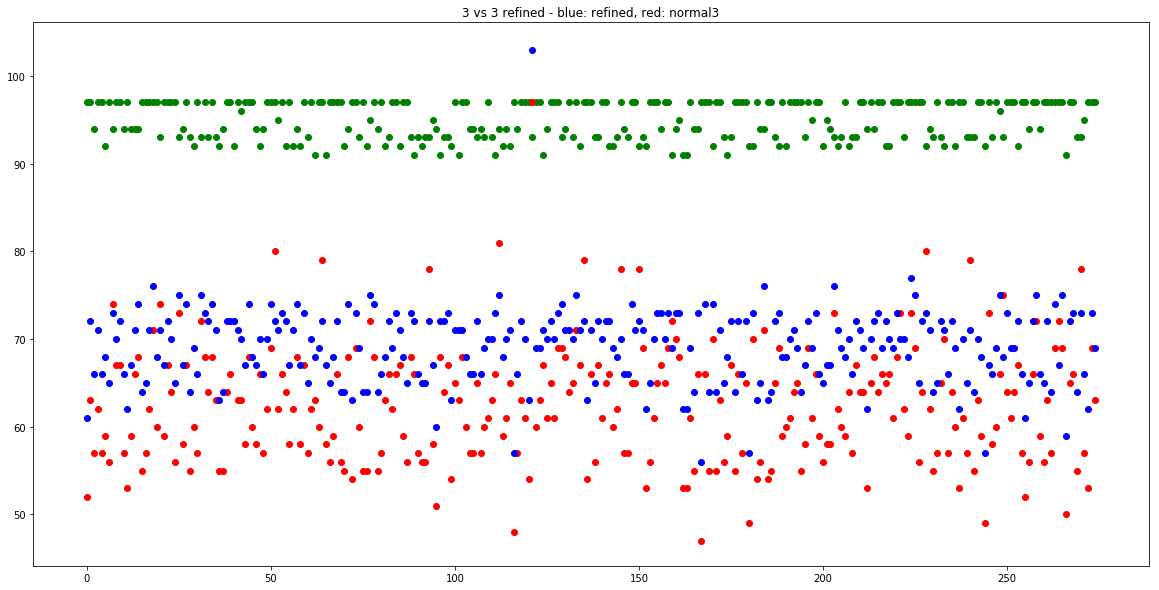

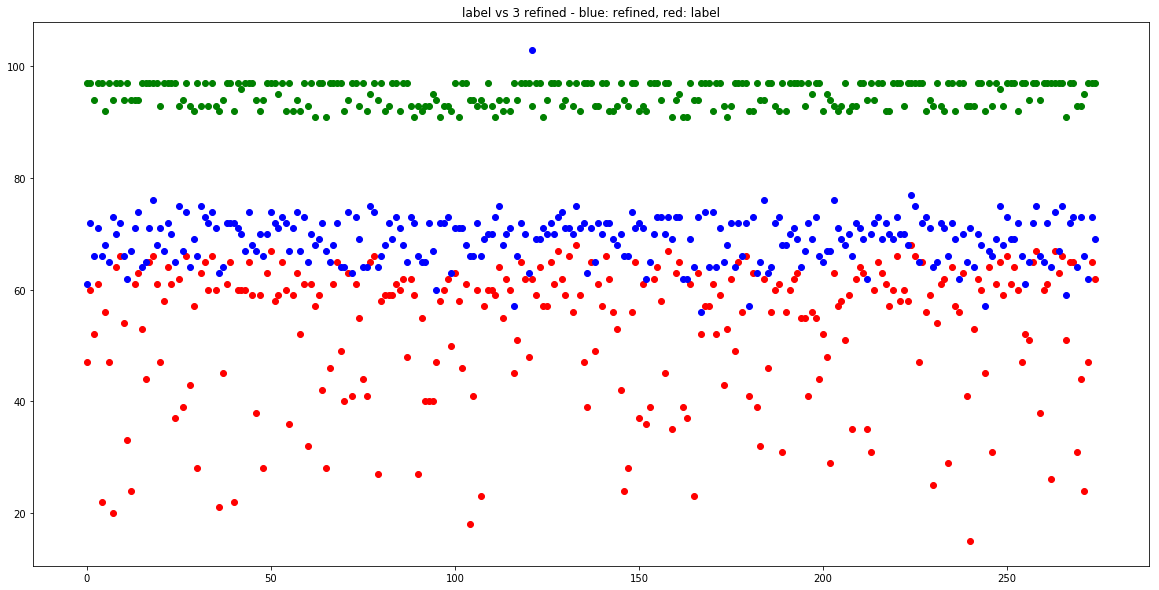

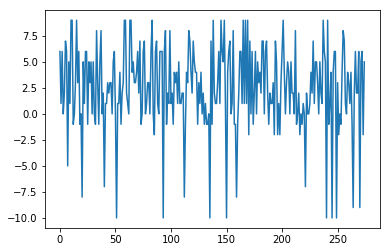

2.44727272727


In [17]:
# print(np.array(outputs).shape)
# new = np.array(outputs)[:, 0, :]
#new = np.append(np.array([outputs[0][1], outputs[0][2]]), np.array(new), axis = 0)
def scatter_plot(l):
    plt.scatter(np.arange(len(l[0])),l[0], label = "labs", c = "green")
    plt.scatter(np.arange(len(l[0])), l[1], label = "3", c = "red")
    plt.scatter(np.arange(len(l[0])), l[2], label = "4", c="blue")

# SHOW LABELS SEPERATED BY WINDUP AND STRETCH
inds = np.where(np.array(dic["position"])=="Windup")[0]
inds_st = np.where(np.array(dic["position"])=="Stretch")[0]
vals_wind = np.array(dic["label"])[inds]
vals_stretch = np.array(dic["label"])[inds_st]

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(vals_wind, bins= np.arange(0, 110))
plt.title("windup")
plt.subplot(1,2,2)
plt.hist(vals_stretch, bins= np.arange(0, 110))
plt.title("stretch")
plt.show()

# WINDUP
every_3_wind = np.array(dic["every_3"])[inds]
every_4_wind =  np.array(dic["every_4"])[inds]
fig = plt.figure(figsize = (20,10))
# plt.style.use('ggplot')
plt.subplot(1,2,1)
scatter_plot([vals_wind, every_3_wind, every_4_wind])
plt.title("windup")
# plt.legend()
# plt.show()

# STRETCH
every_3_set = np.array(dic["every_3"])[inds_st]
every_4_set =  np.array(dic["every_4"])[inds_st]
# plt.style.use('ggplot')
plt.subplot(1,2,2)
scatter_plot([vals_stretch, every_3_set, every_4_set])
plt.title("stretch")
plt.legend()
plt.show()

# ALL
fig = plt.figure(figsize = (20,10))
# plt.style.use('ggplot')
scatter_plot([dic["label"], dic["every_3"], dic["every_4"]])
plt.legend()
plt.title("ALL")
plt.show()
#plt.grid(True)
#from matplotlib2tikz import save as tikz_save
#tikz_save('test.tex')

# COMPARE 3 and 3 refined_nograd:
fig = plt.figure(figsize = (20,10))
scatter_plot([dic["release"], dic["every_3"], dic["3_refined_nograd"]])
plt.title("3 vs 3 refined - blue: refined, red: normal3")
plt.show()

# COMPARE labels and 3 refined_nograd:
fig = plt.figure(figsize = (20,10))
scatter_plot([dic["release"], dic["label"], dic["3_refined_nograd"]])
plt.title("label vs 3 refined - blue: refined, red: label")
plt.show()

# DIFFERENCE FROM EACH OTHER
label_error = np.array(dic["3_refined"])-np.array(dic["every_3"])
plt.plot(label_error)
plt.show()
print(np.mean(label_error))

In [ ]:
for i in range(7):
    for j in range(275):
        new[i,j] = float(new[i,j])

#dic = {"release": new[0].tolist(), "label": new[1].tolist(), "every_2":new[2].tolist(), "every_3":new[3].tolist(), "every_4":new[4].tolist(), "every_5":new[5].tolist(), "3_refined":new[6].tolist()}
dic["position"] = position[:275]
with open("all_first_move_tests.json", "w") as outfile:
    json.dump(dic, outfile)

# Stabilization

In [ ]:
def optical_flow(file):
    cap = cv2.VideoCapture(file)
    arr = []
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 100,
                           qualityLevel = 0.3,
                           minDistance = 7,
                           blockSize = 7 )
    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = (15,15),
                      maxLevel = 2,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # Create some random colors
    color = np.random.randint(0,255,(100,3))
    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    print(old_frame.shape)
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)
    move = [0,0]
    for i in range(100): #while(1):
        ret,frame = cap.read()
        if frame is None:
            break
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for j,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[j].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[j].tolist(),-1)
        img = cv2.add(frame,mask)
        move+= np.mean(good_new-good_old, axis = 0)
        mean_move = np.around(move).astype(int)
        print(np.mean(good_new-good_old, axis = 0))
        print(mean_move)
        if i>70:
            plt.imshow(img)
            plt.show()
        new = np.roll(frame, -mean_move[0], axis = 0)
        new = np.roll(new, -mean_move[1], axis = 1)
        arr.append(new[20:-20, 20:-20, :])
        #k = cv2.waitKey(30) & 0xff
        #if k == 27:
         #   break
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    cv2.destroyAllWindows()
    cap.release()
    return np.array(arr)
    
example ="#9 RHP Ryan King (2)" #9 RHP Ryan King # #48 RHP Tom Flippin # 8 RHP Cole Johnson #15 Brandon Coborn # #10 Matt Glomb #26 RHP Tim Willites" (willites camera moves) #00 RHP Devin Smith
BASE = "/Users/ninawiedemann/Desktop/UNI/Praktikum/high_quality_testing/pitcher/"+example+".mp4" #"data/Matt_Blais/" # für batter: pic davor, 03 streichen und (int(idx+1))
array = optical_flow(BASE)
from skvideo import io
io.vwrite("stabilize.mp4", array)

# Person detector opencv

In [ ]:
# construct the argument parse and parse the arguments

 
# initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

for imagePath in ["/Volumes/Nina Backup/Nina's Pitch/bsp_images/cloudy_ball.jpg"]:
    # load the image and resize it to (1) reduce detection time
    # and (2) improve detection accuracy
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=min(400, image.shape[1]))
    orig = image.copy()
    tic = time.time()
    # detect people in the image
    (rects, weights) = hog.detectMultiScale(image, winStride=(2, 2),
        padding=(4, 4), scale=1.09)
    print("time", time.time()-tic)
    # draw the original bounding boxes
    for (x, y, w, h) in rects:
        cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # apply non-maxima suppression to the bounding boxes using a
    # fairly large overlap threshold to try to maintain overlapping
    # boxes that are still people
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    pick = non_max_suppression(rects, probs=None, overlapThresh=0.65)

    # draw the final bounding boxes
    for (xA, yA, xB, yB) in pick:
        cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

    # show some information on the number of bounding boxes
    filename = imagePath[imagePath.rfind("/") + 1:]
    print("[INFO] {}: {} original boxes, {} after suppression".format(
        filename, len(rects), len(pick)))

    # show the output images
    plt.imshow(orig)
    plt.show()
    plt.imshow(image)
    plt.show()

In [87]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


[580 148] [148 580]


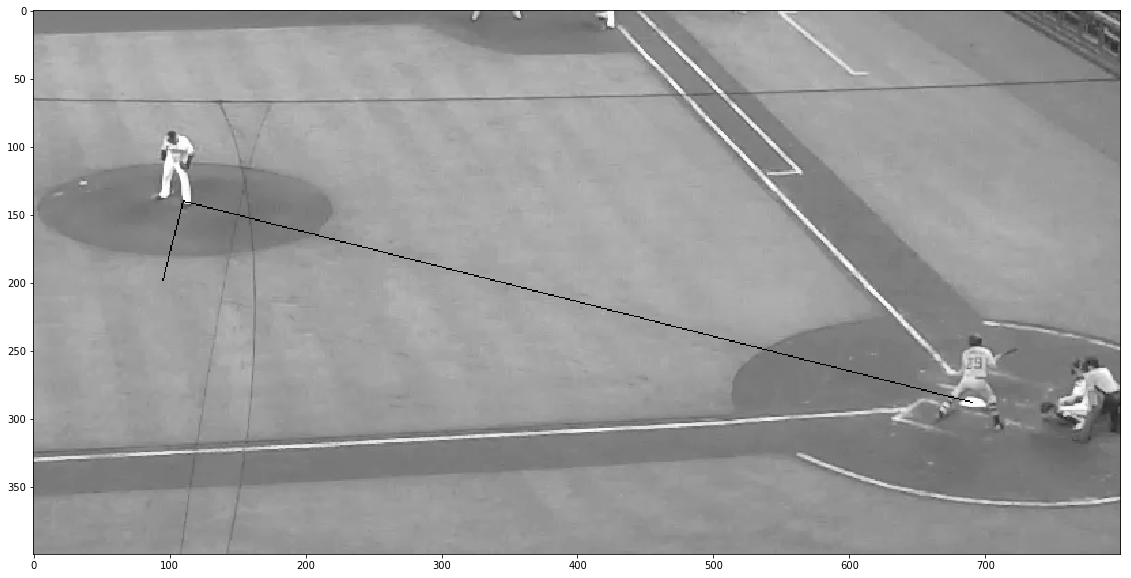

In [83]:
path = "/Volumes/Nina Backup/videos/atl/2017-05-22/side view/"
p1 = np.array([110, 140])
p2 = np.array([690, 288])
vec = (p2-p1)
print(vec, np.array([vec[1], vec[0]]))
p3 = (p1+0.1*np.array([-vec[1], vec[0]])).astype(int)
for BASE in os.listdir(path)[:1]:
    if BASE[-4:]!=".m4v":
        continue
    cap = cv2.VideoCapture(path+BASE)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)[400:800, 600:1400]
    # frame[140, 110]=0   #[288, 690]=0 #280:290, 680:700] = 0
    frame = cv2.line(frame, tuple(p2), tuple(p1), color = 1)
    frame = cv2.line(frame, tuple(p1), tuple(p3), color = 1)
    plt.figure(figsize = (20,10))
    plt.imshow(frame)
    plt.gray()
    plt.show()

In [35]:
distance = np.linalg.norm(np.array([140, 110])- np.array([288, 690]))
print(distance)


598.584998141


In [88]:
p = np.array([300, 100])
dist = np.cos(angle_between(p-p1, p2-p1)) * np.linalg.norm(p-p1)
print(dist)
print(distance_projected(p, p1, p2))

174.210847789
174.210847789


In [72]:
print(np.cross(np.array(690,288)-np.array(110, 140), np.array(110, 140)- np.array(300,500)))
#/np.linalg.norm(np.array(110, 140)-np.array(690,288))

TypeError: data type not understood

In [97]:
first_bbox = [-1,1]
second_bbox = [-2,2]
angle = np.arctan((first_bbox[1]-second_bbox[1])/(first_bbox[0]-second_bbox[0]))
print(angle)

-0.785398163397


In [ ]:
sv = pd.read_csv("/Users/ninawiedemann/Desktop/UNI/Praktikum/ALL/sv_data.csv")
rel = sv["pitch_frame_index"].values
print(np.unique(sv["pitch_frame_index"].values))
plt.hist(rel)